# Introducción Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

In [30]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

data_2019 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/flujo-vehicular-2019.csv')
data_2018 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/flujo-vehicular-2018.csv')
data_2017 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/flujo-vehicular-2017.csv')

Mounted at /content/gdrive


In [31]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [32]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [33]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

In [34]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [35]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [36]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [37]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [38]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [39]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [40]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [41]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

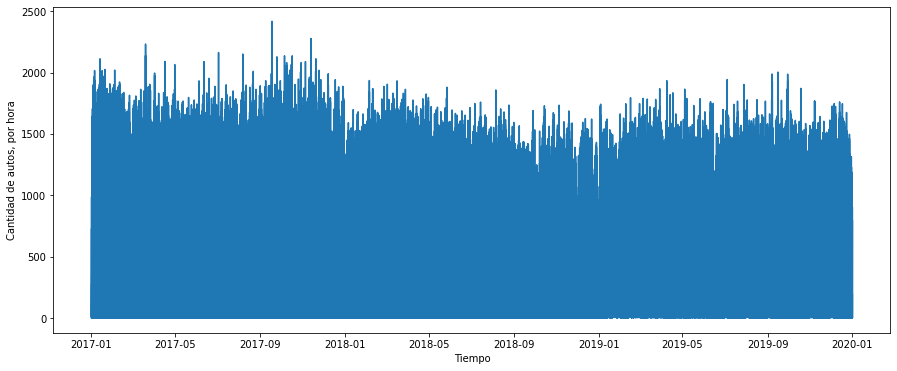

In [42]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [43]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

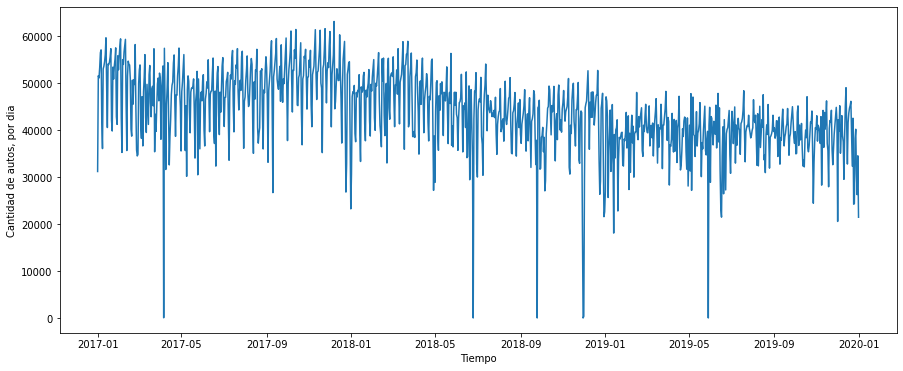

In [44]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

# Resolución del sprint project
Hasta aquí:
*   En dataset → dia,	sentido,	tipo_vehiculo,	cantidad_pasos,	fecha
*   En diario  → fecha, cantidad de pasos

In [45]:
#Save Point

nombre_dataset = "dataset.csv"
direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'

dataset.to_csv(direccion_carpeta + nombre_dataset)
print(dataset.shape)

nombre_dataset = "diario.csv"
diario.to_csv(direccion_carpeta + nombre_dataset)
print(diario.shape)

(238869, 5)
(1095, 1)


In [49]:
#Restore Point
import pandas as pd
# Para importar el dataset
from google.colab import drive
drive.mount('/content/gdrive')

direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'
nombre_dataset = "dataset.csv"
dataset= pd.read_csv(direccion_carpeta + nombre_dataset)
if 'Unnamed: 0' in dataset.columns:
  dataset.drop(columns=['Unnamed: 0'],inplace=True)
  print('Se elimino Unnamed: 0')
print(dataset.shape)

nombre_dataset = "diario.csv"
diario = pd.read_csv(direccion_carpeta + nombre_dataset)
if 'Unnamed: 0' in diario.columns:
  diario.drop(columns=['Unnamed: 0'],inplace=True)
  print('Se elimino Unnamed: 0')
print(diario.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Se elimino Unnamed: 0
(238869, 5)
(1095, 2)


## Exploración de datos

In [50]:
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos                fecha
0  Domingo  Provincia        Pesado               1  2017-01-01 00:00:00
1  Domingo  Provincia       Liviano               9  2017-01-01 00:00:00
2  Domingo  Provincia       Liviano             644  2017-01-01 00:00:00
3  Domingo  Provincia        Pesado               6  2017-01-01 00:00:00
4  Domingo  Provincia        Pesado               1  2017-01-01 00:00:00

In [51]:
# Analizo las variables categoricas
print('tipo_vehiculo ↓')
print(dataset.tipo_vehiculo.unique())
print('sentido ↓')
print(dataset.sentido.unique())
print('dia ↓')
print(dataset.dia.unique())

tipo_vehiculo ↓
['Pesado' 'Liviano']
sentido ↓
['Provincia' 'Centro']
dia ↓
['Domingo' 'Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado']


In [52]:
# Armo sub-datasets separando por tipo de vehiculo  para investigar comportamientos
# Para analizar con mayor detalle, voy a tomar una fraccion del tiempo.
tiempo_inicio ='2018-04-01 00:00:00'
tiempo_fin= '2018-04-08 00:00:00'
mascara_vehiculo =  (dataset.loc[:,'tipo_vehiculo'] == 'Liviano' ) & (dataset.loc[:,'fecha'] >= tiempo_inicio ) & (dataset.loc[:,'fecha'] < tiempo_fin )
data_liviano=dataset[mascara_vehiculo]
print(data_liviano.shape)
mascara_vehiculo =  (dataset.loc[:,'tipo_vehiculo'] == 'Pesado' ) & (dataset.loc[:,'fecha'] >= tiempo_inicio ) & (dataset.loc[:,'fecha'] < tiempo_fin )
data_pesado=dataset[mascara_vehiculo]
print(data_pesado.shape)

(672, 5)
(1293, 5)


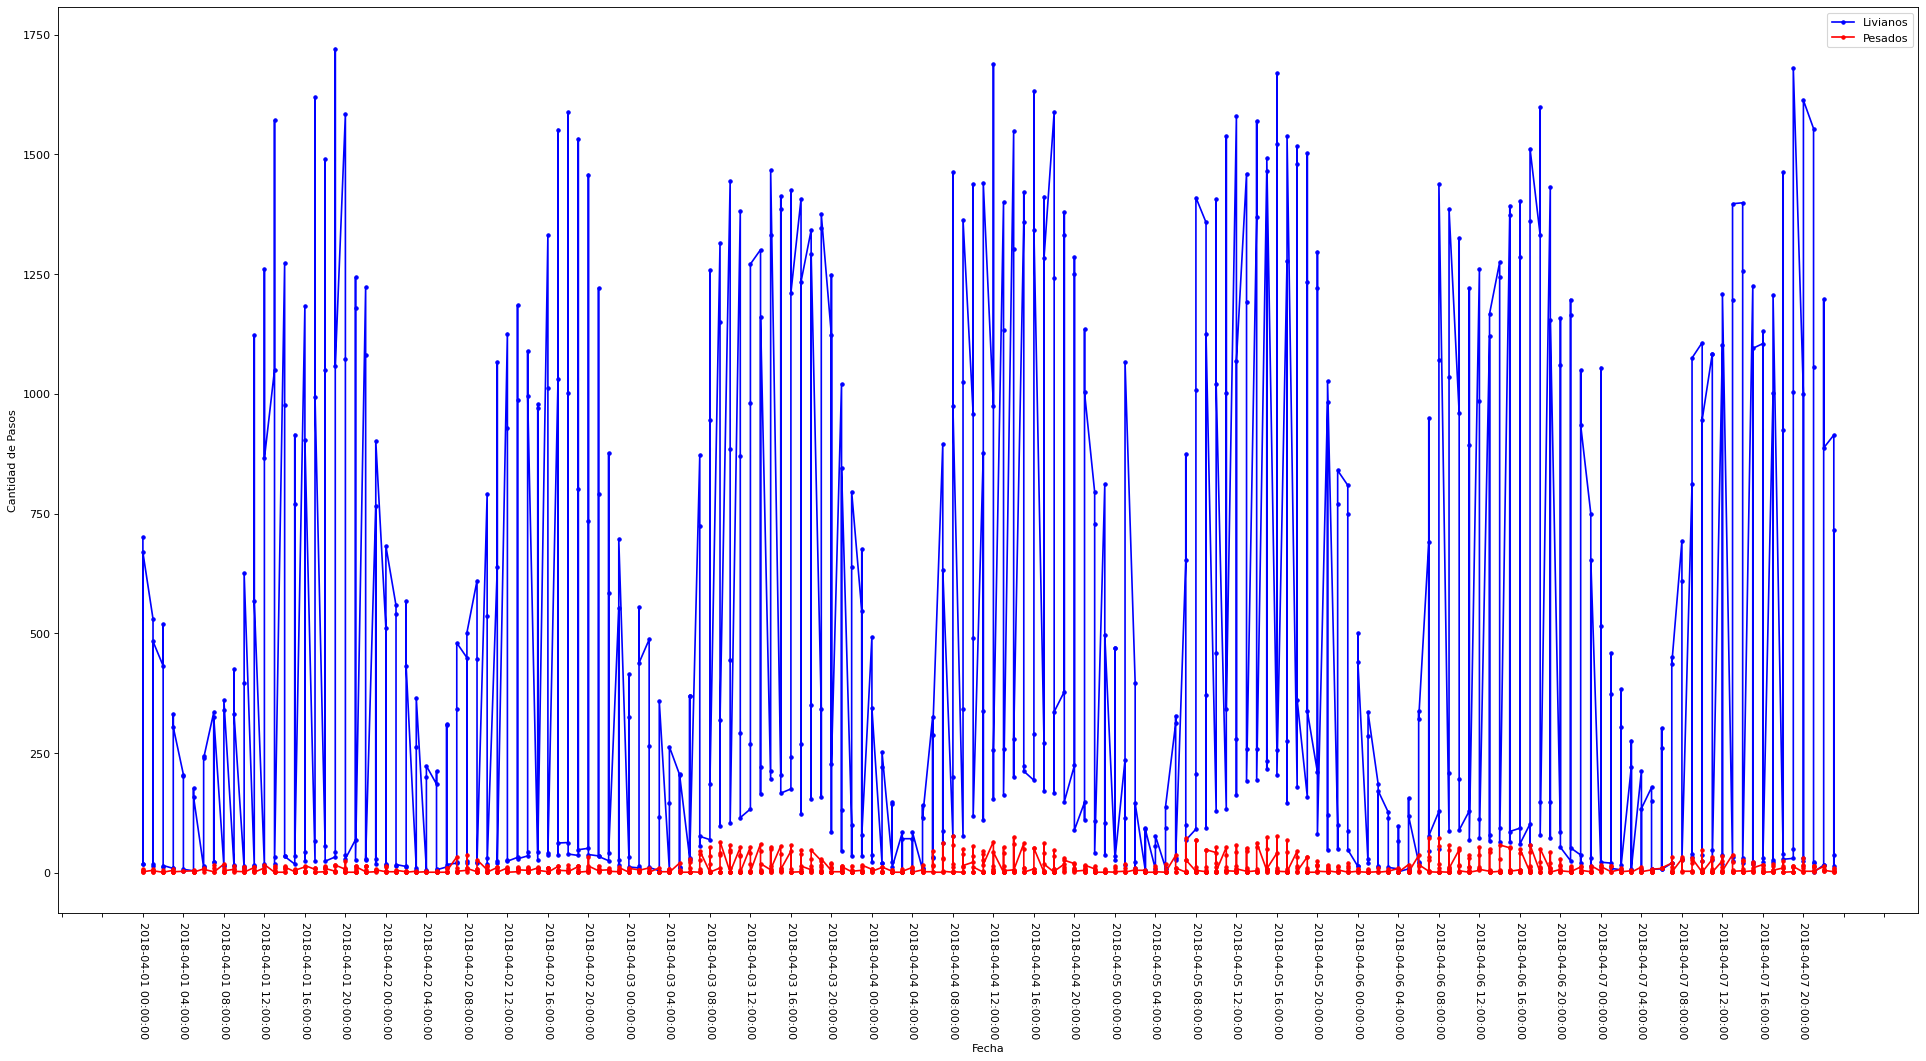

In [53]:
# Grafico 
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos, 'b.-', label = 'Livianos')
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos, 'r.-', label = 'Pesados')
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

Observando la gráfica se ve que el paso de vehículos es períodico con el tiempo. Hay horarios donde hay mas circulación de vehículos livianos, generalmente entre las 8hs y 10hs durante la mañana y por la tarde entre las 17hs y las 21hs. Como también se observa que durante entre las 0hs y las 6hs el flujo vehicular es mínimo. Por otra parte los transportes pesados tienen el mismo horario pico, esto puede llevar a la conclusión de que si los traportes pesados, que son lentos y ocupan vastante lugar en la autopista, llevan su horario pico a la madrugada/noche, descomprimiría bastante el tráfico y a su vez podrían ir mas rápido para transportar las mercaderías, esto conlleva a un ahorro de tiempo y de combustible.

## Componentes de la serie

In [54]:
diario.head()

fecha  cantidad_pasos
0  2017-01-01           31183
1  2017-01-02           51568
2  2017-01-03           51093
3  2017-01-04           53332
4  2017-01-05           56486

In [55]:
# Calculo la tendencia por el a travéz del Rolling Window, para ello utlizo el dataframe diario.
ventana = 7 
promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
promedio_tendencia.describe()

count     1089.000000
mean     43744.300144
std       5244.917581
min      25761.142857
25%      39664.571429
50%      43702.000000
75%      47878.142857
max      54098.000000
Name: cantidad_pasos, dtype: float64

In [56]:
promedio_tendencia.head()

0             NaN
1             NaN
2             NaN
3    48904.285714
4    49601.714286
Name: cantidad_pasos, dtype: float64

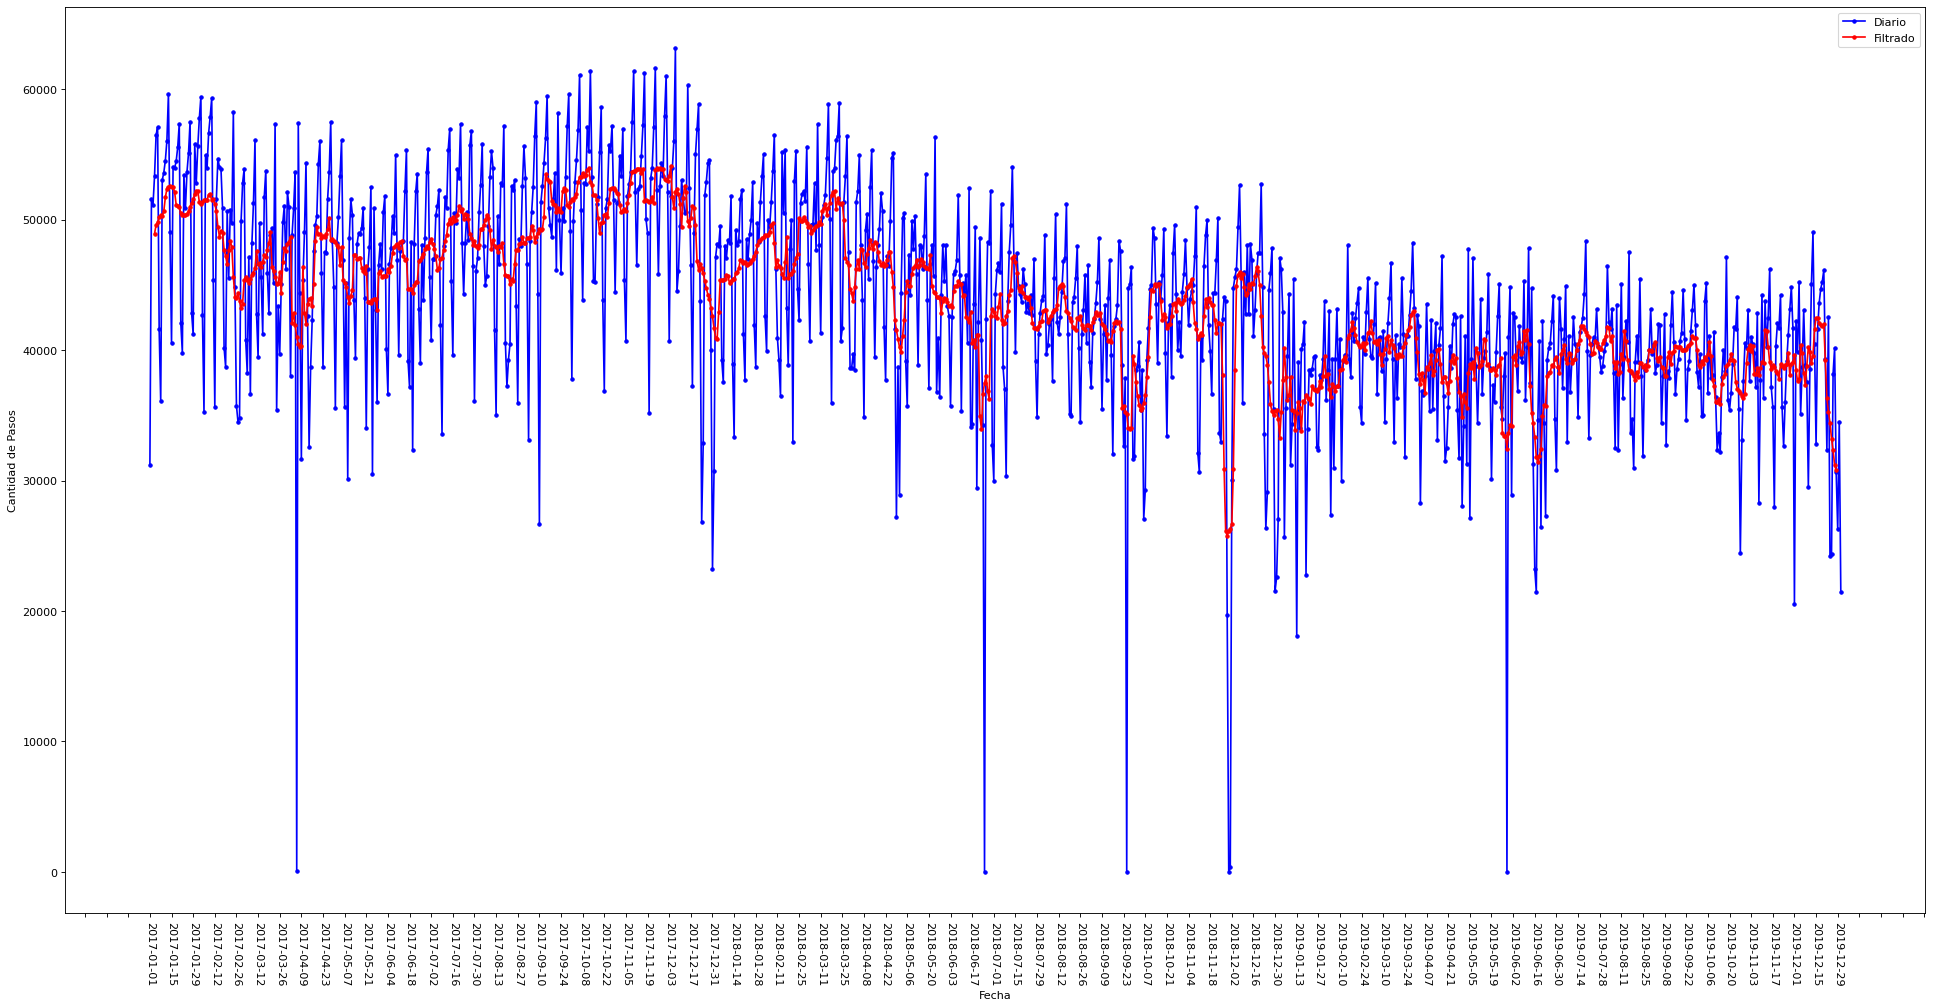

In [57]:
#Grafico 
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario.fecha, diario.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'Filtrado')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [58]:
# Noto que hay outliers, trato de filtrarlos.
diario.cantidad_pasos[diario.cantidad_pasos < 500] = np.nan
diario=diario.interpolate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
#Save Point
direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'
nombre_dataset = "diario.csv"
diario.to_csv(direccion_carpeta + nombre_dataset)
print(diario.shape)

(1095, 2)


In [65]:
#Restore Point
import pandas as pd
# Para importar el dataset
from google.colab import drive
drive.mount('/content/gdrive')

direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'
nombre_dataset = "diario.csv"
diario = pd.read_csv(direccion_carpeta + nombre_dataset)
if 'Unnamed: 0' in diario.columns:
  diario.drop(columns=['Unnamed: 0'],inplace=True)
  print('Se elimino Unnamed: 0')
print(diario.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Se elimino Unnamed: 0
(1095, 2)


In [66]:
#Vuelvo a realizar el ventaneo  con un valor distinto y grafico.
# Calculo la tendencia por el a travéz del Rolling Window, para ello utlizo el dataframe diario.
ventana = 30
promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()

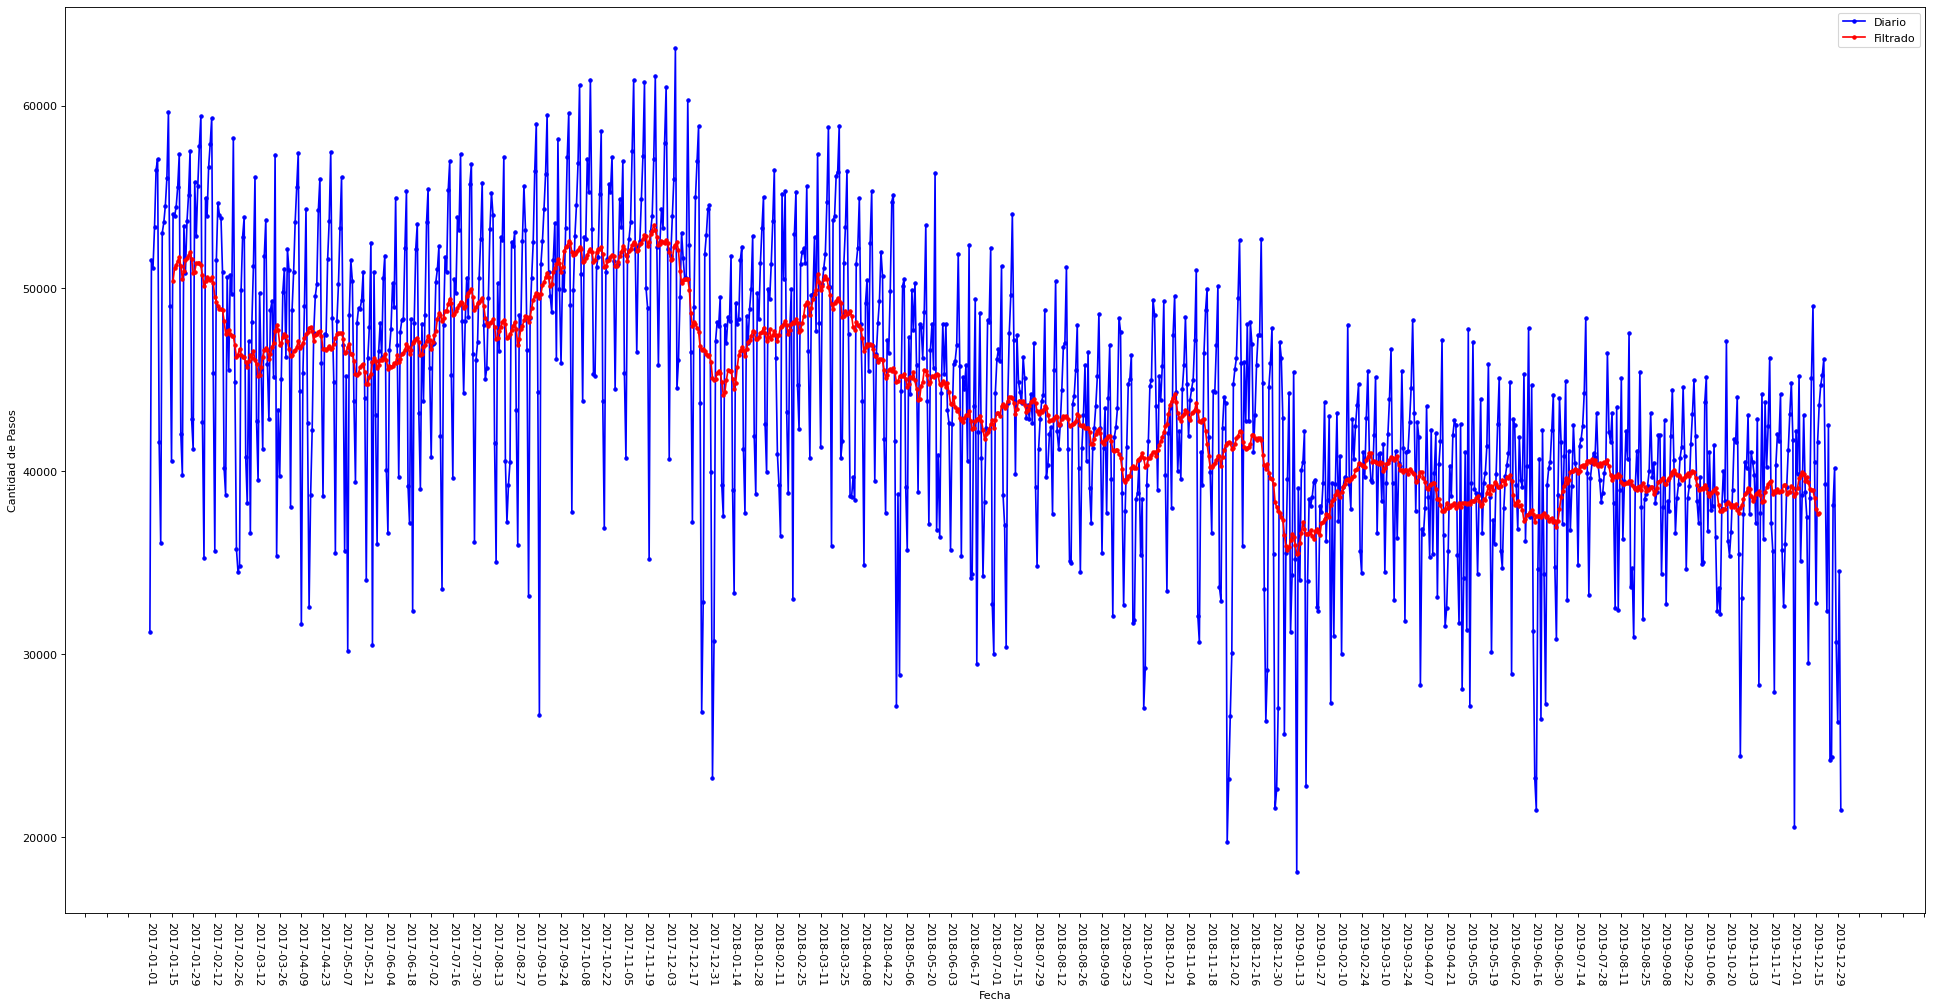

In [67]:
#Grafico 
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario.fecha, diario.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'Filtrado')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

In [68]:
# Hallo la tendencia lineal
lr = LinearRegression()
lr.fit(diario.index.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

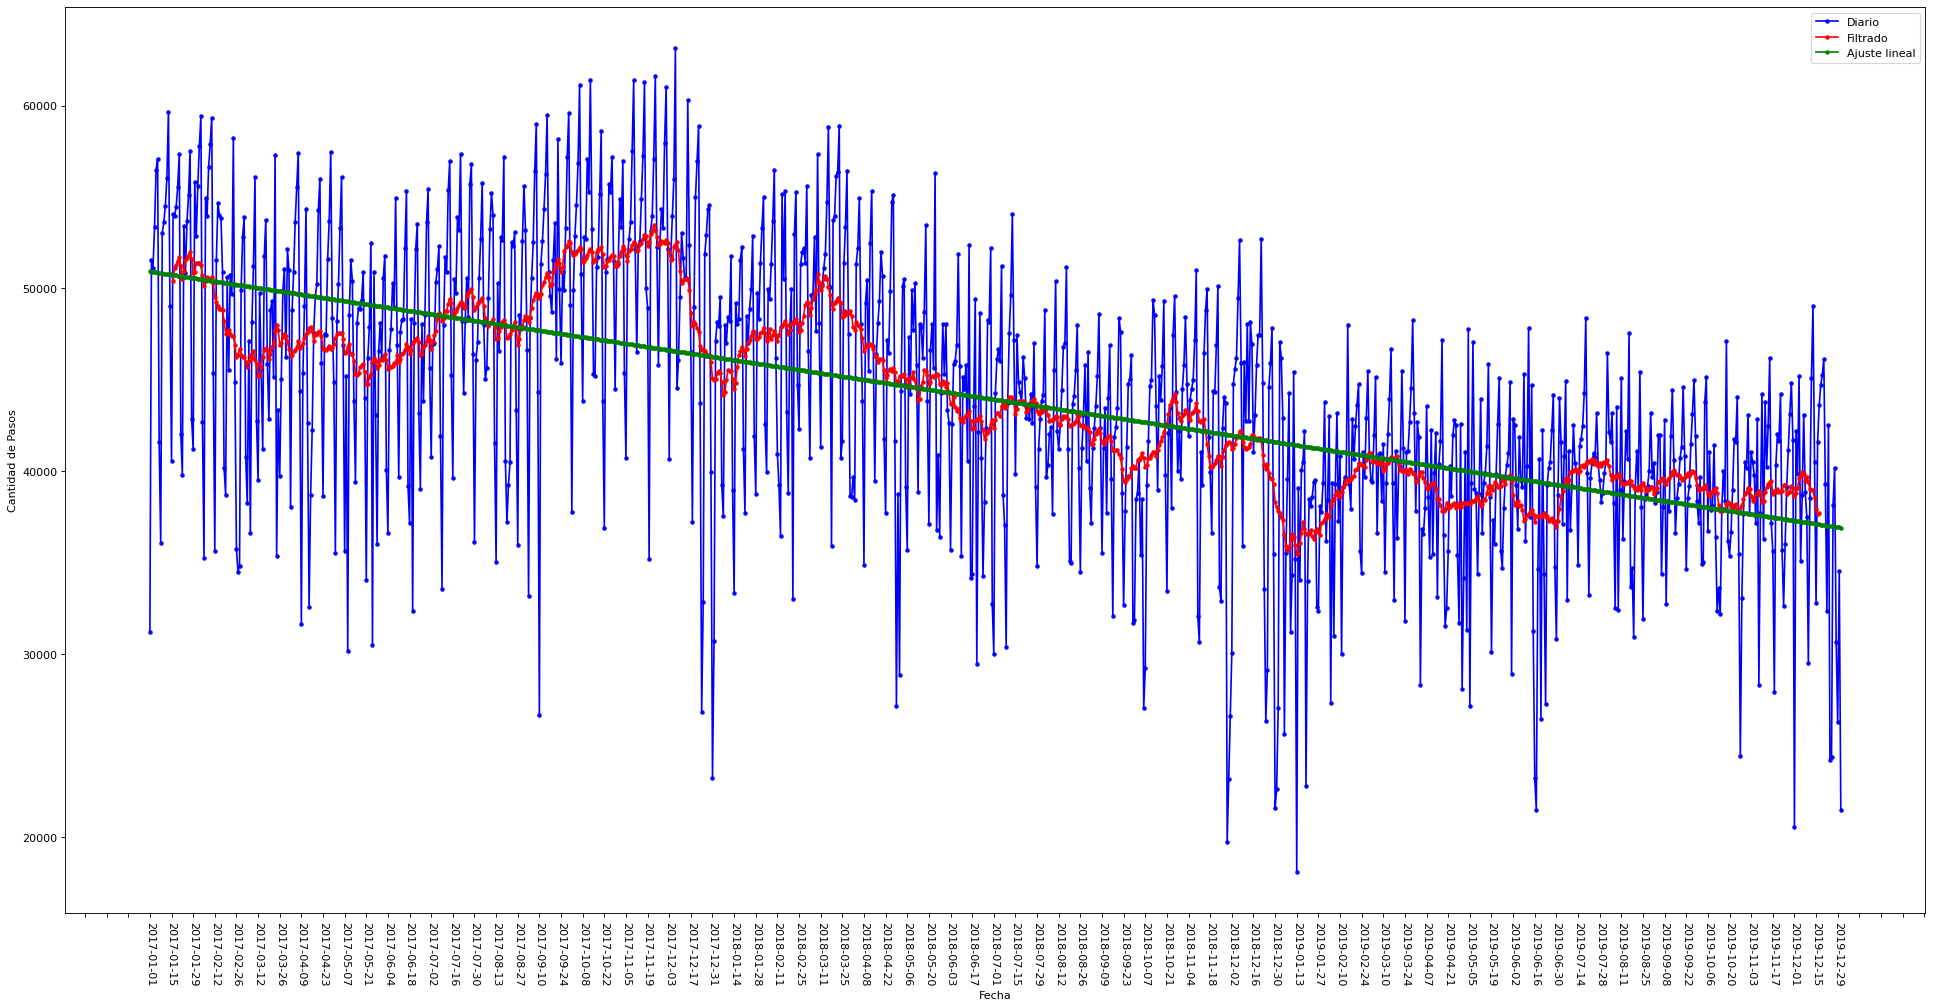

In [69]:
# Grafico los resultados 
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario.fecha, diario.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'Filtrado')
plt.plot(diario.fecha, lr.predict(diario.index.values.reshape(-1, 1)), 'g.-',label = 'Ajuste lineal')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

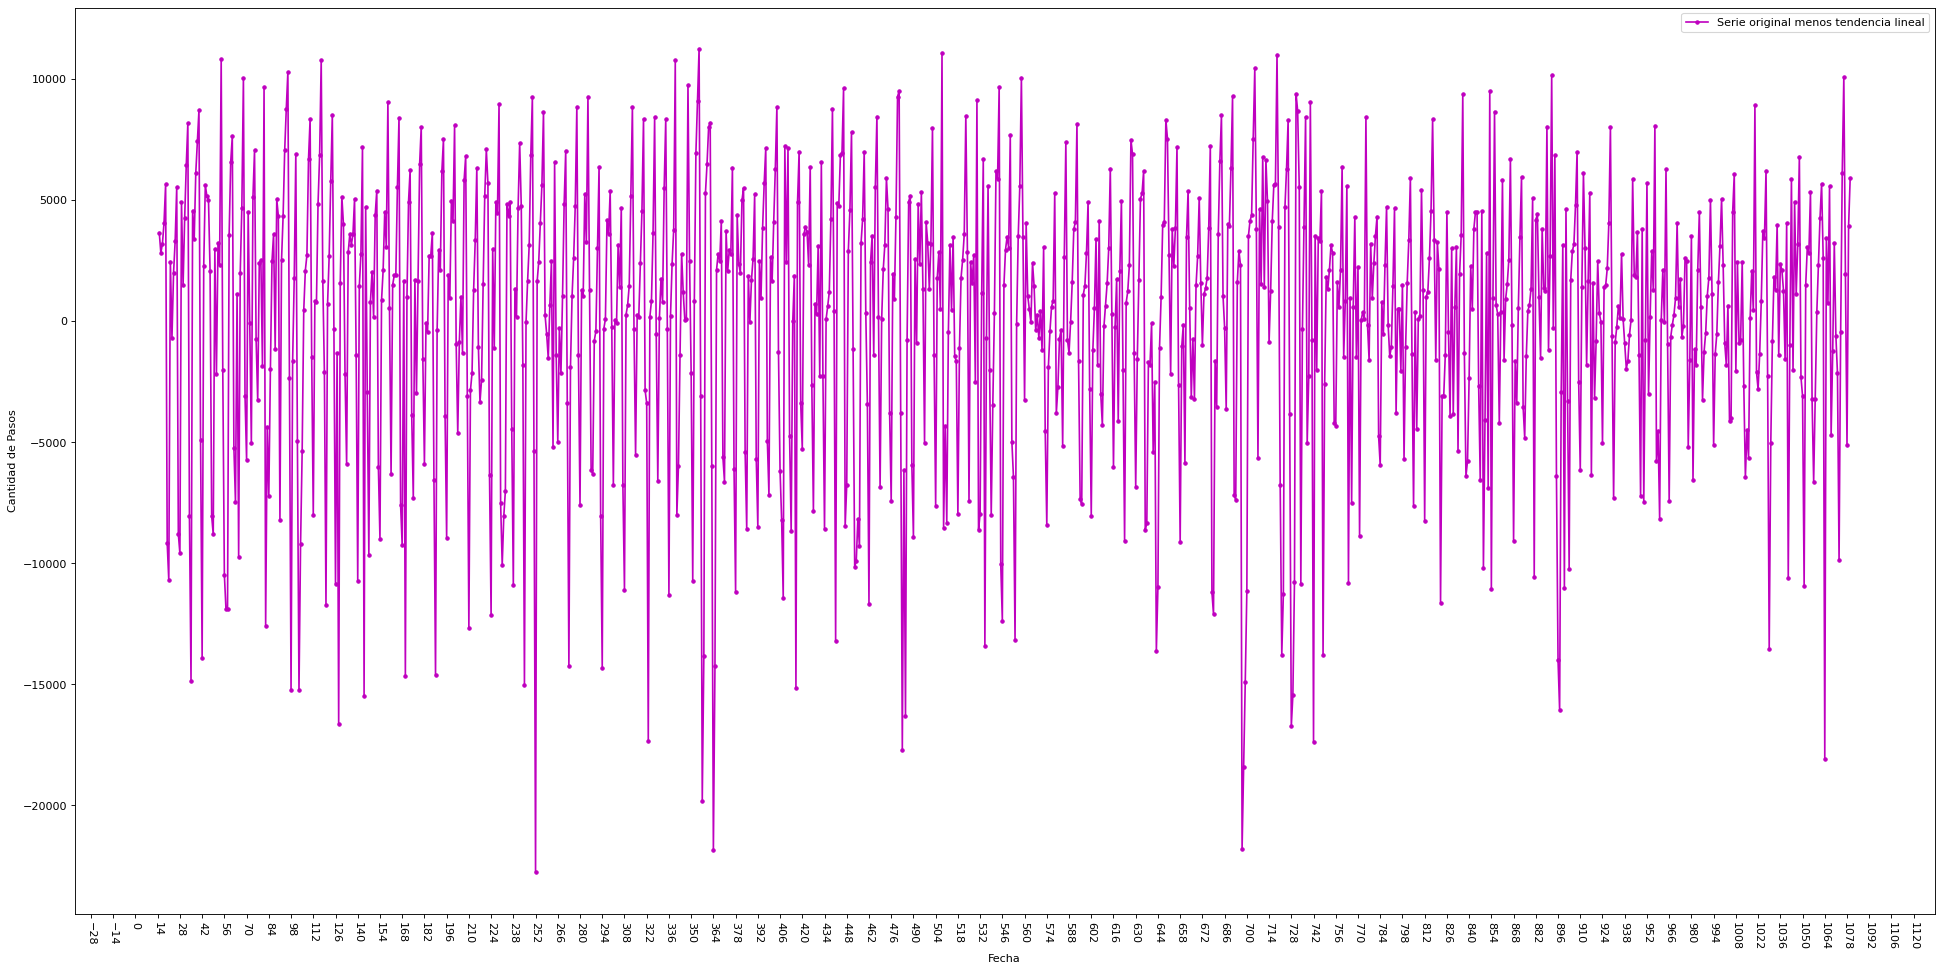

In [70]:
# Ahora trato de hallar la parte estacionaria
# Para ello realizo la diferencia entre la serie original y la tendencia lineal
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)

plt.plot(promedio_tendencia.index, diario.cantidad_pasos-promedio_tendencia, 'm.-', label = 'Serie original menos tendencia lineal')
#plt.plot(diario.fecha, diario.cantidad_pasos-lr.predict(diario.index.values.reshape(-1, 1)), 'm.-', label = 'Serie original menos tendencia lineal')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

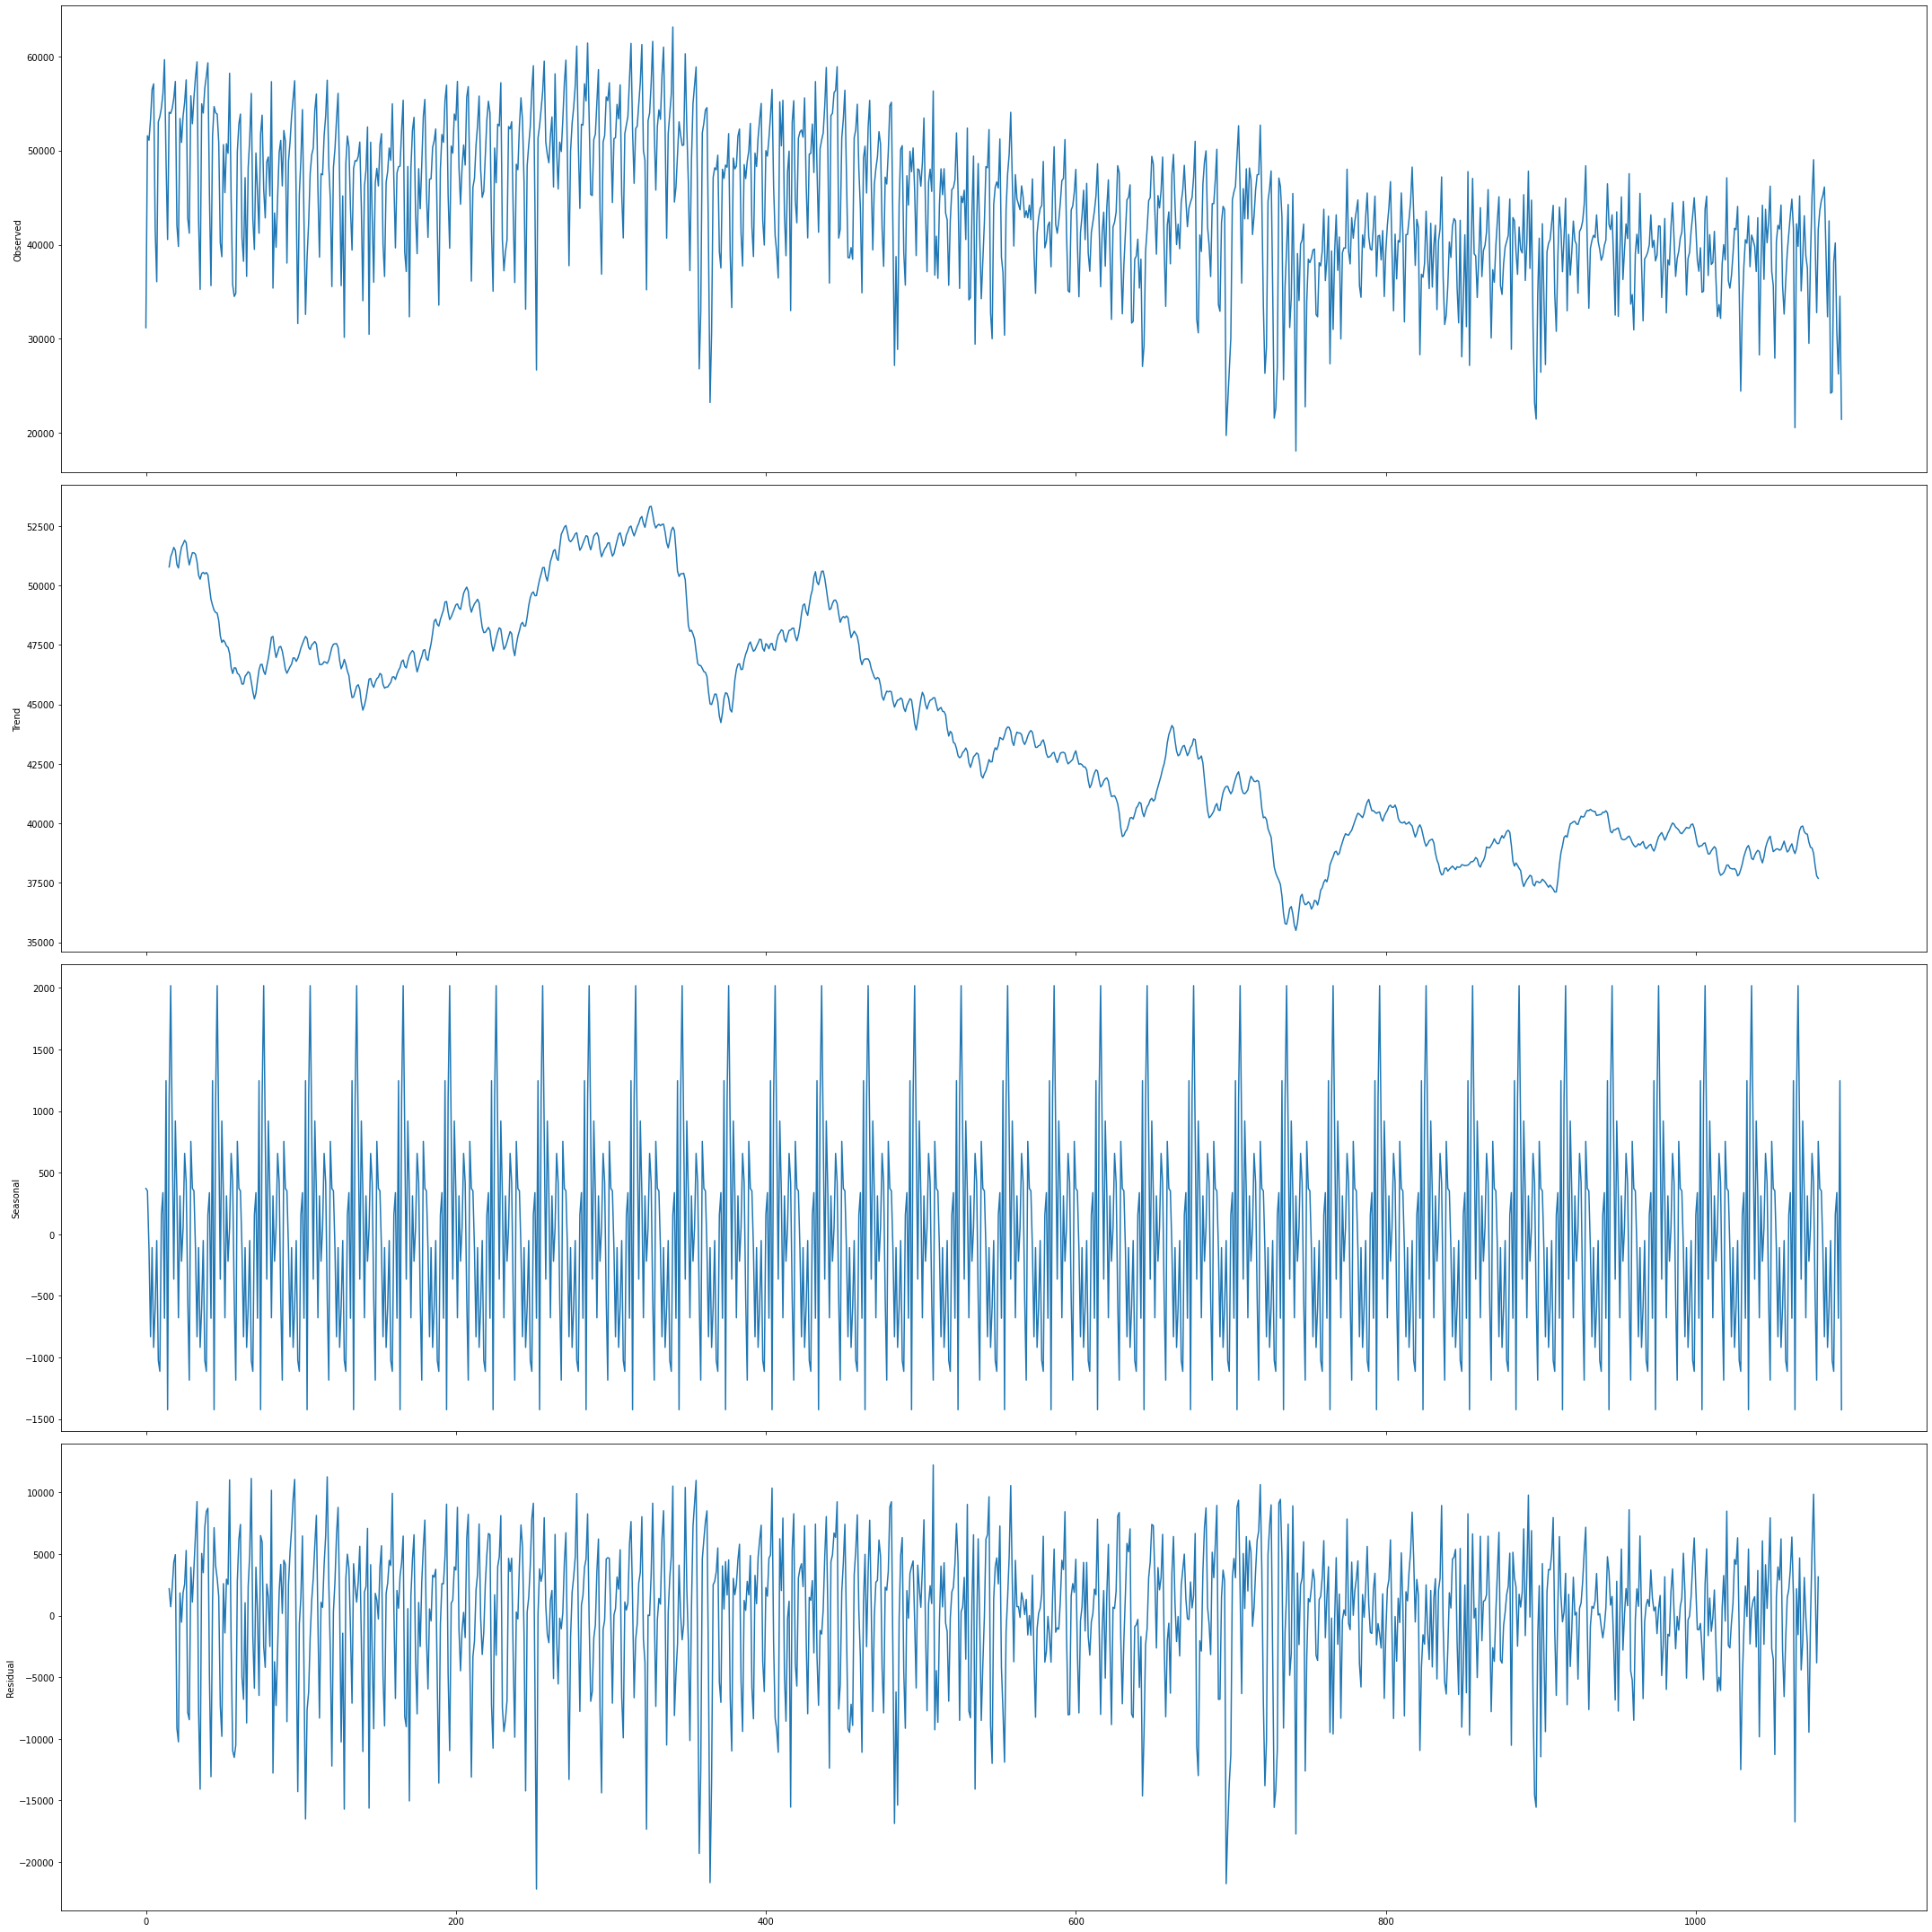

In [71]:
#Ahora pruebo con la librería de Statsmodels para realizar otro procedimiento y lueo comparar.
freq_=30
result = seasonal_decompose(diario.cantidad_pasos, freq=freq_, model='additive')
plt.rcParams['figure.figsize'] = [30,30]
result.plot()
plt.show()

Se observa que claramente la serie tiene tendencia decreciente con una componente esacional entre +2000 y -1500 vehículos por día. Por último la parte residual entre +1000 y -2000 indica los extremos de la serie que es vastante fluctuante. 
Analizando mas en profundidad la tendencia decreciente, la tendencia de patentamiento (ver el [link](https://www.latdf.com.ar/2020/02/evolucion-de-la-venta-de-autos-0km-en.html)) de nuevos vehículos en argentina es decreciente en el período 2017 al 2019. Si bien el hecho de que la tendencia de patentamiento de vehículos sea decreciente, hay que contemplar que los vehículos comprados en 2017 en su mayoría siguen circulando en 2019, es decir que la tendencia acumulada de autos es crecente, lo que indicaría que la tendencia de autos que circula debería ser creciente. 
Es por ello que en este caso habría que interpretar el por que de la tendencia decresiente. 
Hablo mas del tema en la sección de conclusiones.

## Predicción a Futuro

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


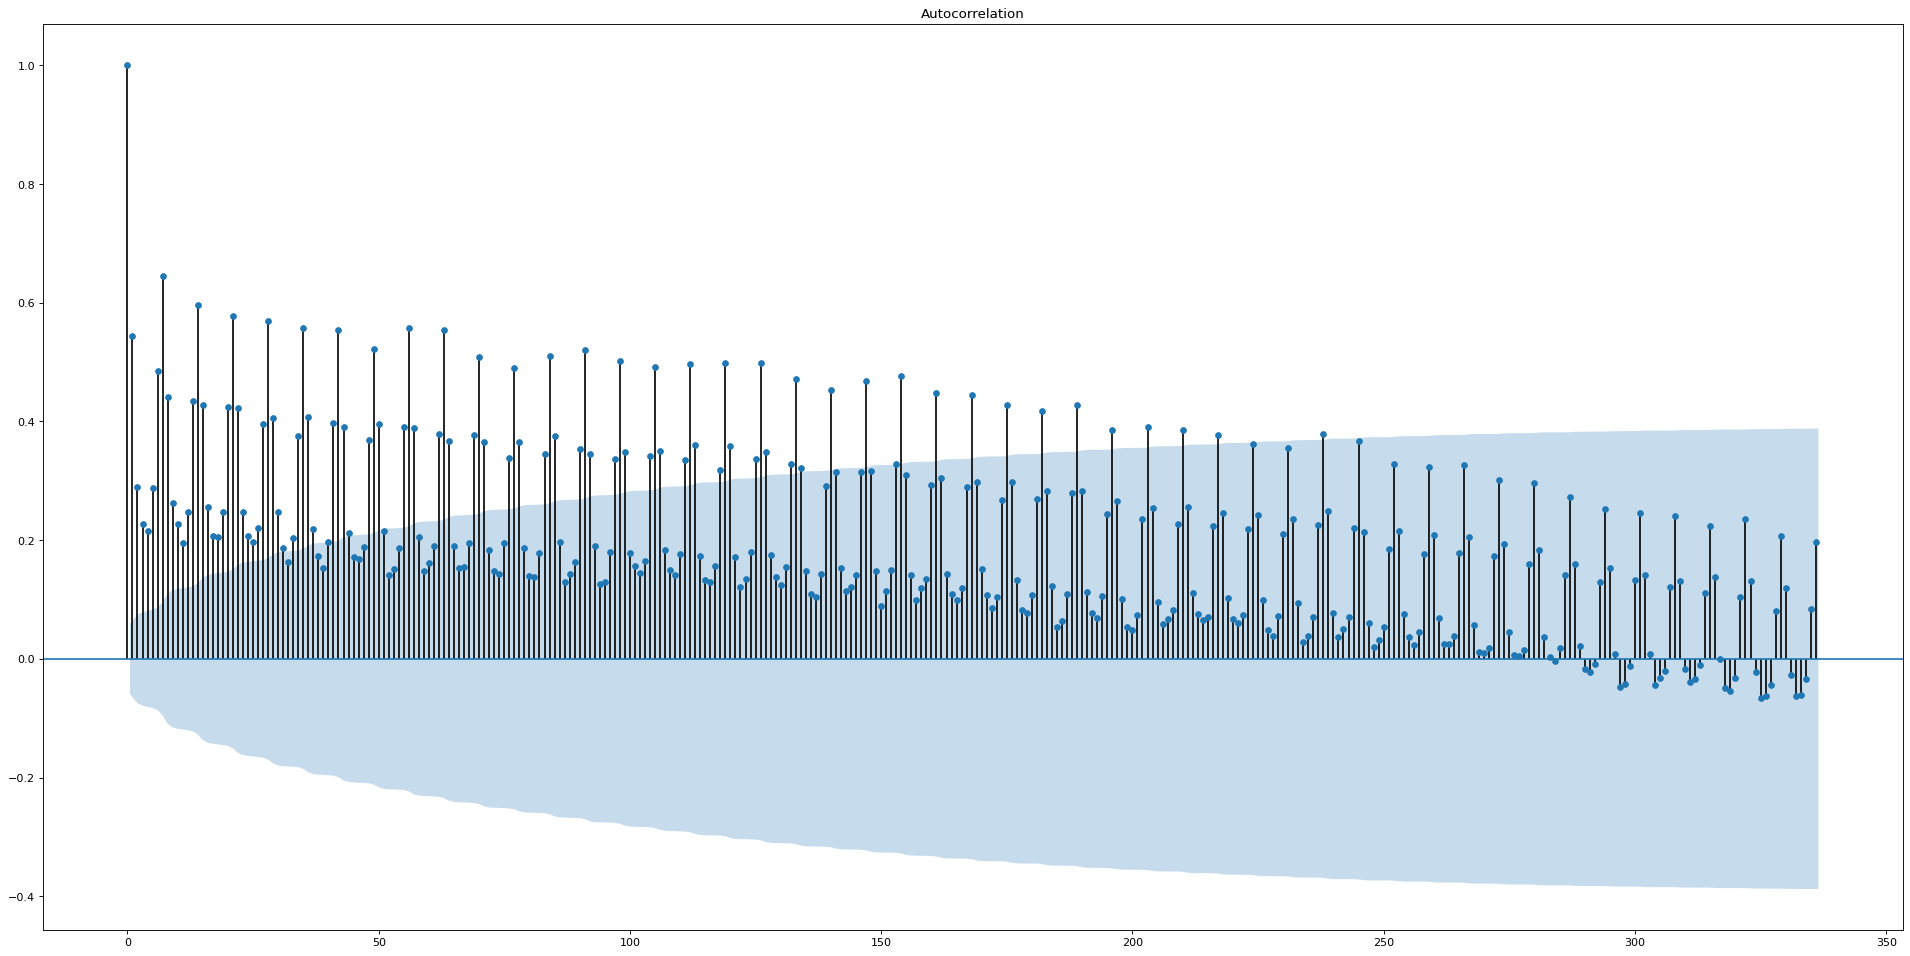

In [72]:
# En principio analizo la autocorrelación. Esto me va a indicar cuanto se parece la serie a si misma.
# Obtengo auto correlación
nlags =  28 * 12
autocorr = acf(diario.cantidad_pasos, nlags = nlags)

# La grafico
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plot_acf(diario.cantidad_pasos, lags =nlags,ax=ax)
plt.show()

Claramente hay una correlación importante cada 7 días como era de esperarse. Es decir el tráfico de un domingo suele ser parecido al de otro domingo. También se observa una envolvente decreciente, esto quiere decir que a lo largo del tiempo la serie se parece cada vez menos a si misma.

In [73]:
# Ahora comienzo a trabajar en la búsqueda y realización de un predictor
diario = diario.rename(columns={'cantidad_pasos': 'y'})
#senial = diario.y.astype(int)
senial = diario.y
senial.shape

(1095,)

In [74]:
# Preparo los datos en train y test 
look_back = 30 # Cantidad de dias que voy a usar para prdecir el siguiente valor
steps = 92  # Cantidad de valores que quiero predecir

# Armo la matrices X e y que vendrian a ser el nuevo data set
N = senial.shape[0] # cantidad total de elementos de la serie de tiempo
X = np.zeros((N - look_back - 1,look_back))  # (N - look_back - 1) → filas  y (look_back) → columnas
y = np.zeros(N - look_back - 1) # (N - look_back - 1) → filas
print(X.shape,y.shape)
 # Relleno los valores de las matrices X e y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

X_train = X[:-steps,:]
y_train = y[:-steps]
print(X_train.shape, y_train.shape)

X_test = X[-steps:,:]
y_test = y[-steps:]
print(X_test.shape, y_test.shape)

(1064, 30) (1064,)
(972, 30) (972,)
(92, 30) (92,)


In [75]:
# Armo el regressor y lo entreno
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

# Predigo
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculo el error RMSE en train y test.
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))


Error en Train: 1832.7676269950691
Error en Test: 5014.661592834718


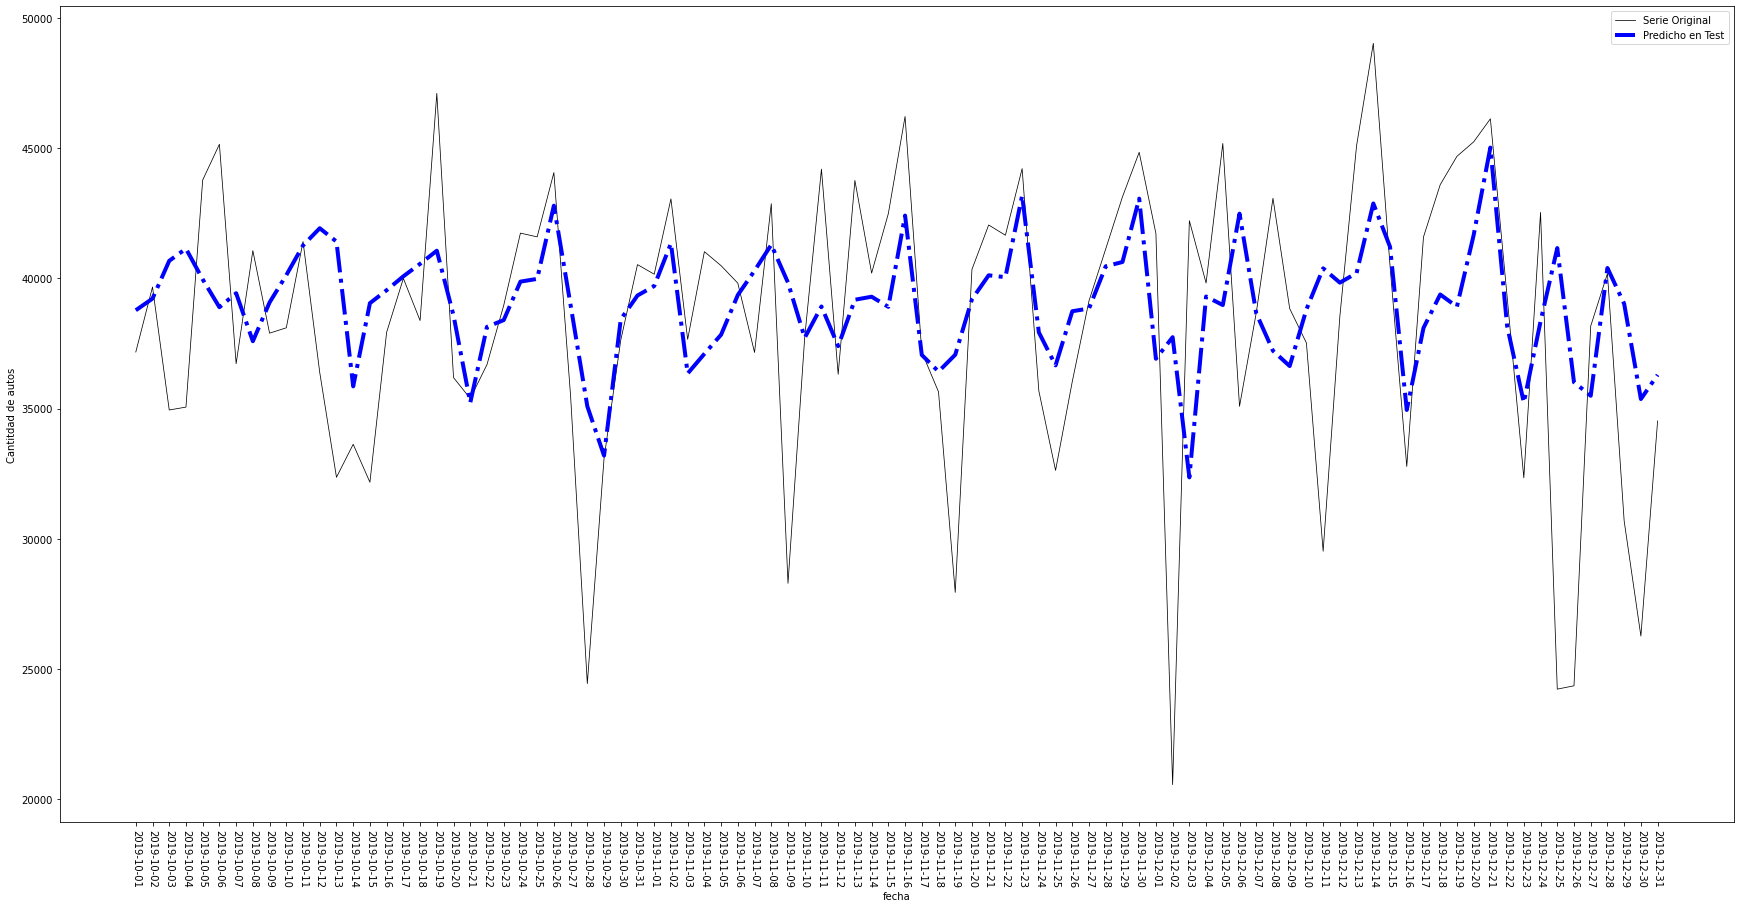

In [76]:
# Grafico la parte de test
plt.figure(figsize=(30,15))
plt.plot(diario.fecha[-steps:], y_test,lw = 0.75, label = 'Serie Original',color = "black")
plt.plot(diario.fecha[-steps:], y_test_pred,'-.', lw = 4, label = 'Predicho en Test', color = "blue")
plt.legend()
plt.xticks(rotation=-90)
plt.xlabel('fecha')
plt.ylabel('Cantitdad de autos')
plt.show()

In [77]:
# Ahora pruebo cambiando la cantidad de elementos con los que voy a entrenar el regresor 
# Preparo los datos en train y test 
look_back = 30 # Cantidad de dias que voy a usar para prdecir el siguiente valor
steps = 92  # Cantidad de valores que quiero predecir
train_days = 365*2 # cantidad de dias que voy a utlizar para entrenar

# Armo la matrices X e y que vendrian a ser el nuevo data set
N = senial.shape[0] # cantidad total de elementos de la serie de tiempo
X = np.zeros((N - look_back - 1,look_back))  # (N - look_back - 1) → filas  y (look_back) → columnas
y = np.zeros(N - look_back - 1) # (N - look_back - 1) → filas
print(X.shape,y.shape)
 # Relleno los valores de las matrices X e y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

X_train = X[-train_days-steps:-steps,:]
y_train = y[-train_days-steps:-steps]
print(X_train.shape, y_train.shape)

X_test = X[-steps:,:]
y_test = y[-steps:]
print(X_test.shape, y_test.shape)

# Armo el regressor y lo entreno
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

# Predigo
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculo el error RMSE en train y test.
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))


(1064, 30) (1064,)
(730, 30) (730,)
(92, 30) (92,)
Error en Train: 1866.9464402919089
Error en Test: 4983.175924749358


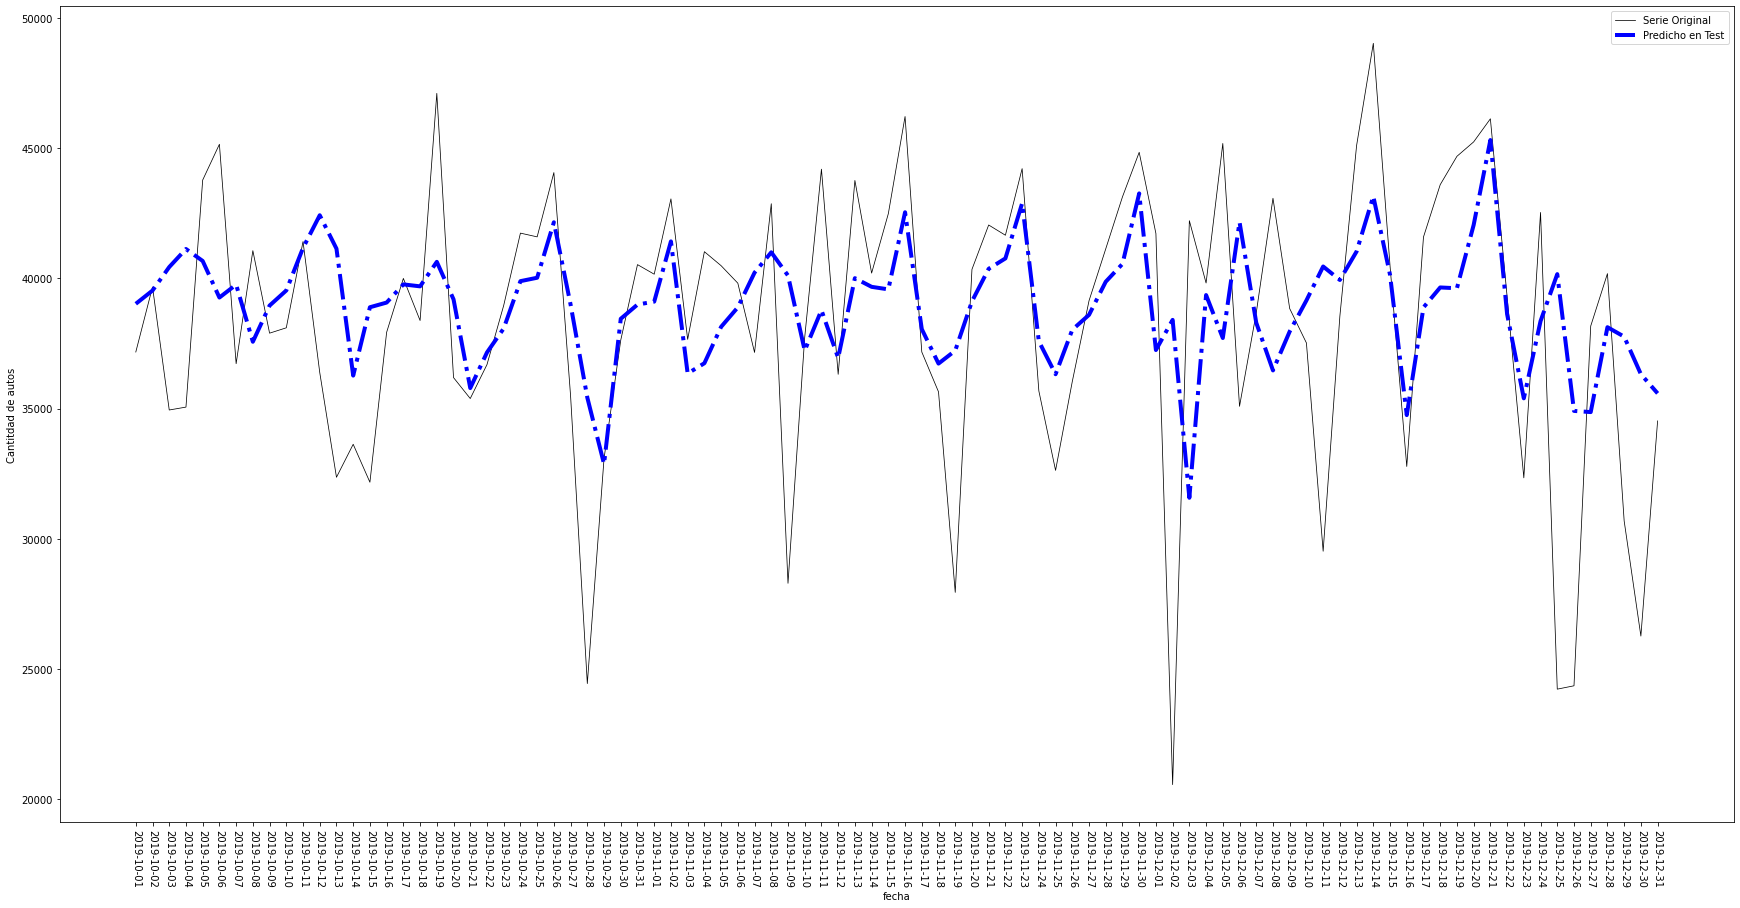

In [78]:
# Grafico la parte de test
plt.figure(figsize=(30,15))
plt.plot(diario.fecha[-steps:], y_test,lw = 0.75, label = 'Serie Original',color = "black")
plt.plot(diario.fecha[-steps:], y_test_pred,'-.', lw = 4, label = 'Predicho en Test', color = "blue")
plt.legend()
plt.xticks(rotation=-90)
plt.xlabel('fecha')
plt.ylabel('Cantitdad de autos')
plt.show()

In [79]:
# Noto que al cambiar la cantidad de dias de entrenamiento tambien varia la perfonrmanse 
# Es decir que se toma train_days como un hiper parametro a optimizar
# Genero una funcion que recibe los parametros a optimizar y retorna el RMSE
def regressor (senial_,look_back , train_days,n_estimators_):
  # Armo la matrices X e y que vendrian a ser el nuevo data set
  steps=92
  N = senial_.shape[0] # cantidad total de elementos de la serie de tiempo
  X = np.zeros((N - look_back - 1,look_back))  # (N - look_back - 1) → filas  y (look_back) → columnas
  y = np.zeros(N - look_back - 1) # (N - look_back - 1) → filas
  # Relleno los valores de las matrices X e y
  for i in range(X.shape[0]):
      X[i,:] = senial_.iloc[i:i+look_back]
      y[i] = senial_.iloc[i+look_back]

  X_train = X[-train_days-steps:-steps,:]
  y_train = y[-train_days-steps:-steps]
  
  X_test = X[-steps:,:]
  y_test = y[-steps:]
  

  # Armo el regressor y lo entreno
  rf = RandomForestRegressor(n_estimators=n_estimators_,random_state=42, n_jobs = 4).fit(X_train,y_train)

  # Predigo
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  MSE = mean_squared_error(y_test, y_test_pred)
  return np.sqrt(MSE)

In [80]:
# Pruebo el funcionamiento de la función
print(regressor(senial,30,365*2,100))

4983.175924749358


In [81]:
# Para optimizar voy a realizar un random search a mano
# Para ello armo el espacio de búsqueda con valores al azar acotados

#Cantidad de iteraciones
i=100

aux = np.arange(7,90)
look_back=np.random.choice(aux,i)

aux = np.arange(90,int(2.5*360))
train_days = np.random.choice(aux,i)

aux= np.arange(50,600)
n_estimators = np.random.choice(aux,i)

In [82]:
# Comienzo a probar 
resultados=[]
for p in range(i):
  resultados.append(regressor(senial,look_back[p],train_days[p],n_estimators[p]))

resultados

[4849.003058779203,
 4759.9224016579265,
 5105.838317744147,
 4934.057545338744,
 5477.537401492405,
 5094.830584288134,
 4809.353246325871,
 5410.649521902244,
 4755.412199179068,
 5192.1285062421075,
 4918.947860931271,
 4802.126034642242,
 4784.276659081925,
 4851.155412891455,
 5061.570572754954,
 5225.926622361455,
 4975.882969306875,
 4858.922934809528,
 4925.706267207181,
 5210.624140116272,
 4910.981927043896,
 4887.315864464914,
 4808.526574044304,
 4780.1121448126005,
 5049.753175973796,
 4767.844432772528,
 5121.260007636559,
 4763.436941329122,
 4768.166968401323,
 5117.81721355487,
 4924.21302344606,
 4926.000336773766,
 4720.303284720257,
 4701.706087272138,
 5120.551925487579,
 4785.101345915667,
 4803.451925995269,
 4744.434294226073,
 4902.7510681177855,
 5150.219338475395,
 4786.450188286763,
 4836.630929916769,
 5048.29688571827,
 4956.183902665645,
 5176.277323837197,
 4877.371477450788,
 4850.70322234562,
 4888.242493822789,
 4830.379568592363,
 4853.621957400787,


In [83]:
print(min(resultados), resultados.index(min(resultados)))
p=resultados.index(min(resultados))
print(look_back[p],train_days[p],n_estimators[p])


4701.706087272138 33
71 445 543


In [84]:
# Es decir que a partir de la búsqueda, los mejores parámetros encontrados fueron: 
# look_back= 80, train_days=549, y  n_estimators = 209 
# Ahora trato de ampliar la busqueda 

#Cantidad de iteraciones
i=500
# Armo el espacio para la buqueda
aux = np.arange(7,90)
look_back=np.random.choice(aux,i)

aux = np.arange(90,int(2.5*360))
train_days = np.random.choice(aux,i)

aux= np.arange(50,600)
n_estimators = np.random.choice(aux,i)
resultados_a=[]
for p in tqdm(range(i)):
  resultados_a.append(regressor(senial,look_back[p],train_days[p],n_estimators[p]))

100%|██████████| 500/500 [33:21<00:00,  4.00s/it]


In [85]:
print(min(resultados_a), resultados_a.index(min(resultados_a)))
p=resultados_a.index(min(resultados_a))
print(look_back[p],train_days[p],n_estimators[p])

4705.038251553741 143
73 670 337


In [86]:
# Pruebo una vez mas con mas iteraciones 
#Cantidad de iteraciones
i=1000
# Armo el espacio para la buqueda
aux = np.arange(7,90)
look_back=np.random.choice(aux,i)

aux = np.arange(90,int(2.5*360))
train_days = np.random.choice(aux,i)

aux= np.arange(50,600)
n_estimators = np.random.choice(aux,i)
resultados_b=[]
for p in tqdm(range(i)):
  resultados_b.append(regressor(senial,look_back[p],train_days[p],n_estimators[p]))

print(min(resultados_b), resultados_b.index(min(resultados_b)))
p=resultados_b.index(min(resultados_b))
print(look_back[p],train_days[p],n_estimators[p])

100%|██████████| 1000/1000 [1:03:07<00:00,  3.79s/it]

4671.250072889273 578
71 164 401


In [87]:
# Guardo los resultados en un dataframe
data_result = pd.DataFrame()
data_result['look_back']= look_back [:]
data_result['train_days']= train_days[:]
data_result['n_estimators']= n_estimators[:]
data_result['resultado']= resultados_b[:]

data_result.shape

(1000, 4)

In [88]:
print(data_result.loc[[136]])

     look_back  train_days  n_estimators    resultado
136         49         377           341  4870.578665


Aqui es interesante recalcar que en la búsqueda anterior de 500 elemntos se encontró un resultado mejor que en la búsqueda de 1000.
Voy a agregar los valores al dataframe con resultados.

In [89]:
new_row = {'look_back': 67, 'train_days':453, 'n_estimators': 69, 'resultado':4630.919487845931}
data_result=data_result.append(new_row,ignore_index=True )
data_result=data_result.sort_values('resultado')
data_result.reset_index(inplace=True,drop=True)
data_result.head(10)

look_back  train_days  n_estimators    resultado
0       67.0       453.0          69.0  4630.919488
1       71.0       164.0         401.0  4671.250073
2       66.0       163.0          52.0  4680.708134
3       69.0       446.0         324.0  4690.872892
4       71.0       450.0         570.0  4691.609311
5       81.0       396.0         179.0  4701.179507
6       79.0       586.0         425.0  4702.626485
7       68.0       607.0         462.0  4707.471145
8       72.0       395.0         228.0  4707.997601
9       70.0       763.0          75.0  4707.998940

In [91]:
# me guardo el dataframe con los resultados
#Save Point
direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'
nombre_dataset = "data_result.csv"
data_result.to_csv(direccion_carpeta + nombre_dataset)

In [92]:
#Restore Point
import pandas as pd
# Para importar el dataset
from google.colab import drive
drive.mount('/content/gdrive')

direccion_carpeta = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto3/'
nombre_dataset = "data_result.csv"
data_result = pd.read_csv(direccion_carpeta + nombre_dataset)
if 'Unnamed: 0' in data_result.columns:
  data_result.drop(columns=['Unnamed: 0'],inplace=True)
  print('Se elimino Unnamed: 0')
print(data_result.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Se elimino Unnamed: 0
(1001, 4)


In [93]:
# Ahora armo el regresor y el conjunto de datos con los mejores valores hallados
# Preparo los datos en train y test 
look_back = 67 # Cantidad de dias que voy a usar para prdecir el siguiente valor
steps = 92  # Cantidad de valores que quiero predecir
train_days = 453 # cantidad de dias que voy a utlizar para entrenar

# Armo la matrices X e y que vendrian a ser el nuevo data set
N = senial.shape[0] # cantidad total de elementos de la serie de tiempo
X = np.zeros((N - look_back - 1,look_back))  # (N - look_back - 1) → filas  y (look_back) → columnas
y = np.zeros(N - look_back - 1) # (N - look_back - 1) → filas
print(X.shape,y.shape)
 # Relleno los valores de las matrices X e y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

X_train = X[-train_days-steps:-steps,:]
y_train = y[-train_days-steps:-steps]
print(X_train.shape, y_train.shape)

X_test = X[-steps:,:]
y_test = y[-steps:]
print(X_test.shape, y_test.shape)

# Armo el regressor y lo entreno
rf = RandomForestRegressor(n_estimators=69, random_state=42, n_jobs = 4).fit(X_train,y_train)

# Predigo
y_train_pred = rf.predict(X_train)
y_test_pred2 = rf.predict(X_test)

# Calculo el error RMSE en train y test.
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred2)
print('Error en Test:',np.sqrt(MSE))

(1027, 67) (1027,)
(453, 67) (453,)
(92, 67) (92,)
Error en Train: 1897.3012514136528
Error en Test: 4630.919487845931


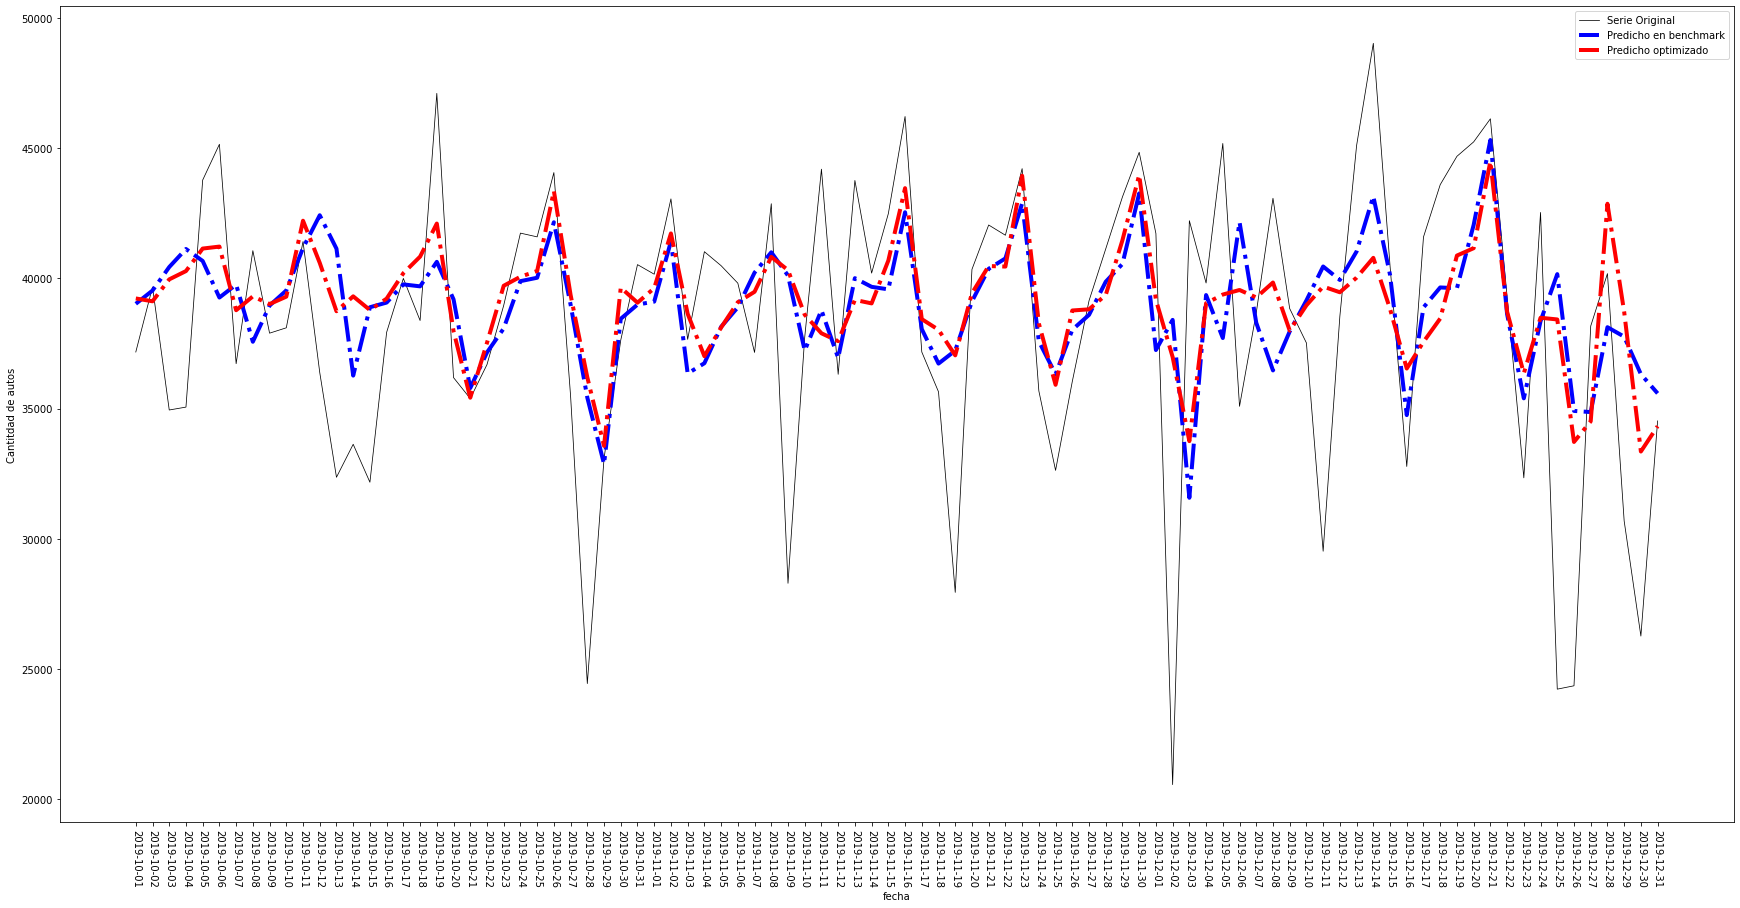

In [94]:
# Grafico los resultados en la zona de test
# Grafico la parte de test
plt.figure(figsize=(30,15))
plt.plot(diario.fecha[-steps:], y_test,lw = 0.75, label = 'Serie Original',color = "black")
plt.plot(diario.fecha[-steps:], y_test_pred,'-.', lw = 4, label = 'Predicho en benchmark', color = "blue")
plt.plot(diario.fecha[-steps:], y_test_pred2,'-.', lw = 4, label = 'Predicho optimizado', color = "red")
plt.legend()
plt.xticks(rotation=-90)
plt.xlabel('fecha')
plt.ylabel('Cantitdad de autos')
plt.show()

## Conclusiones
Importante, entre las cosas que se piden en el TP están la de predecir el tráfico en 2020. Hay que aclarar que el sistema no preveía el cambio abrupto que generó la pandemia en el tema del tránsito vehicular. 

En la sección de exploración de datos logré encontrar algunas cosas interesantes y realicé una propuesta concreta para la mejora de alivianar los horarios pico, por ejemplo, haciendo que los vehículos pesados se pasen a la franja horaria de la noche. Otra forma sería implementar CAR-SHARING, dado que la mayoría de los vehículos solo viaja el conductor, quedando libres hasta cuatro asientos más.

Como bien se muestra en la sección de componentes de la serie, la misma tiene una tendencia decreciente, contrariamente a lo esperado dado que la cantidad de vehículos va en aumento. Esto puede ser atribuido a una cuestión económica, dado que en el período 2017-2019 la economía fue empeorando y moverse en vehículo era cada vez mas caro, muchos decidieron reducir sus viajes en vehículos particulares. Otra explicación puede ser la de la aparición de alguna vía alternativa donde posiblemente no se cobre peaje. 

En cuanto a la sección de predicción a futuro, resulta interesante la metodología para adaptar un regresor el cual se alimenta de N feactures para utlizarlo en series de tiempo el cual posee un solo feacture. La forma de hacerlo es mediante el parámetro look_back con el cual se va armando una matriz de dos dimensiones para generar los N feactures donde cada fila es el imput y el valor siguiente es el output.

Estaría bueno mejorar la forma de buscar hiper parámetros, pero este problema tiene la particularidad que algunos de los parámetros a tunear son externos al regresor, es por ello que armé un buscador random de los mejores parámetros. Se me ocurre que una forma de mejorarlo es implementar un descenso de gradientes. También estaría bueno poder probar con otros algorimos de regresión, incluso implementar redes neuronales mediante Tensor Flow.

Este trabajo me sirvió para aprender y reforzar varios aspectos de este tema no menor en ciencia de datos que es de Series de Tiempo. Vale aclarar que en el estudio de las series de tiempo uno tiene que pensar que el futuro se va a comportar como el pasado y eso no siempre es así. 


## Correcciones
Investigación - j) Objetivo
Rehacer. Partiendo de los mismos datos se deben indicar interrogantes nuevos a resolver.

Investigación - k) Metodología
Rehacer. Resta incluir como sería el desarrollo de los próximos pasos a implementar para resolver otras preguntas con los datos utilizados.

Investigación - l)Implementación (opcional)
No desarrolla.

### Investigación - j) Objetivo
Observando el dataset principal, previo a realizar el drop de las columnas Puedo observar los distintos tipos de pago.
Voy a tratar de realizar un análisis de la evolución de los distintos tipos de pago a lo largo del tiempo.

### Investigación - k) Metodología
Para poder cumplir con el inciso anterior en pincipio voy a determinar cuales son los medios de pagos mas relevantes y luego voy a tratar de armar un nuevo data set, resampleado en dias, para cada medio de pago relevante.
Luego graficaré la evolución temporal de los distintos medios de pago y por último sacaré conclusiones. 
Todo esto, para que los datos sean congruentes con el trabajo que se realizó previamente, se realizará en la estación Illia.

### Investigación - l) Implementación (opcional)

In [95]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = dataset.estacion=='Illia'
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio', 'estacion'], inplace = True)

dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


fecha  hora_fin     dia    sentido tipo_vehiculo  forma_pago  \
19  2019-01-01         1  Martes     Centro       Liviano  NO COBRADO   
20  2019-01-01         1  Martes     Centro       Liviano    TELEPASE   
21  2019-01-01         1  Martes     Centro        Pesado    TELEPASE   
22  2019-01-01         1  Martes  Provincia       Liviano  NO COBRADO   
23  2019-01-01         1  Martes  Provincia       Liviano    TELEPASE   

    cantidad_pasos  
19             146  
20              59  
21               1  
22             147  
23             106

In [96]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

dia    sentido tipo_vehiculo forma_pago  cantidad_pasos      fecha
0  Domingo     Centro       Liviano   TELEPASE             459 2017-01-01
1  Domingo  Provincia        Pesado   TELEPASE               3 2017-01-01
2  Domingo  Provincia        Pesado   EFECTIVO               1 2017-01-01
3  Domingo  Provincia        Pesado   TELEPASE               7 2017-01-01
4  Domingo  Provincia        Pesado   EFECTIVO               6 2017-01-01

In [97]:
# Chequeo las formas de pago que quedaron 
print(dataset['forma_pago'].unique())

['TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION' 'TARJETA DISCAPACIDAD'
 'NO COBRADO' 'MONEDERO' 'T. DISCAPACIDAD']


In [98]:
# Noto que hay dos etiquetas que describen el mismo tipo de pago, procedo a unirlas
dataset['forma_pago']=dataset['forma_pago'].replace(['T. DISCAPACIDAD'],'TARJETA DISCAPACIDAD')
print(dataset['forma_pago'].unique())

['TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION' 'TARJETA DISCAPACIDAD'
 'NO COBRADO' 'MONEDERO']


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

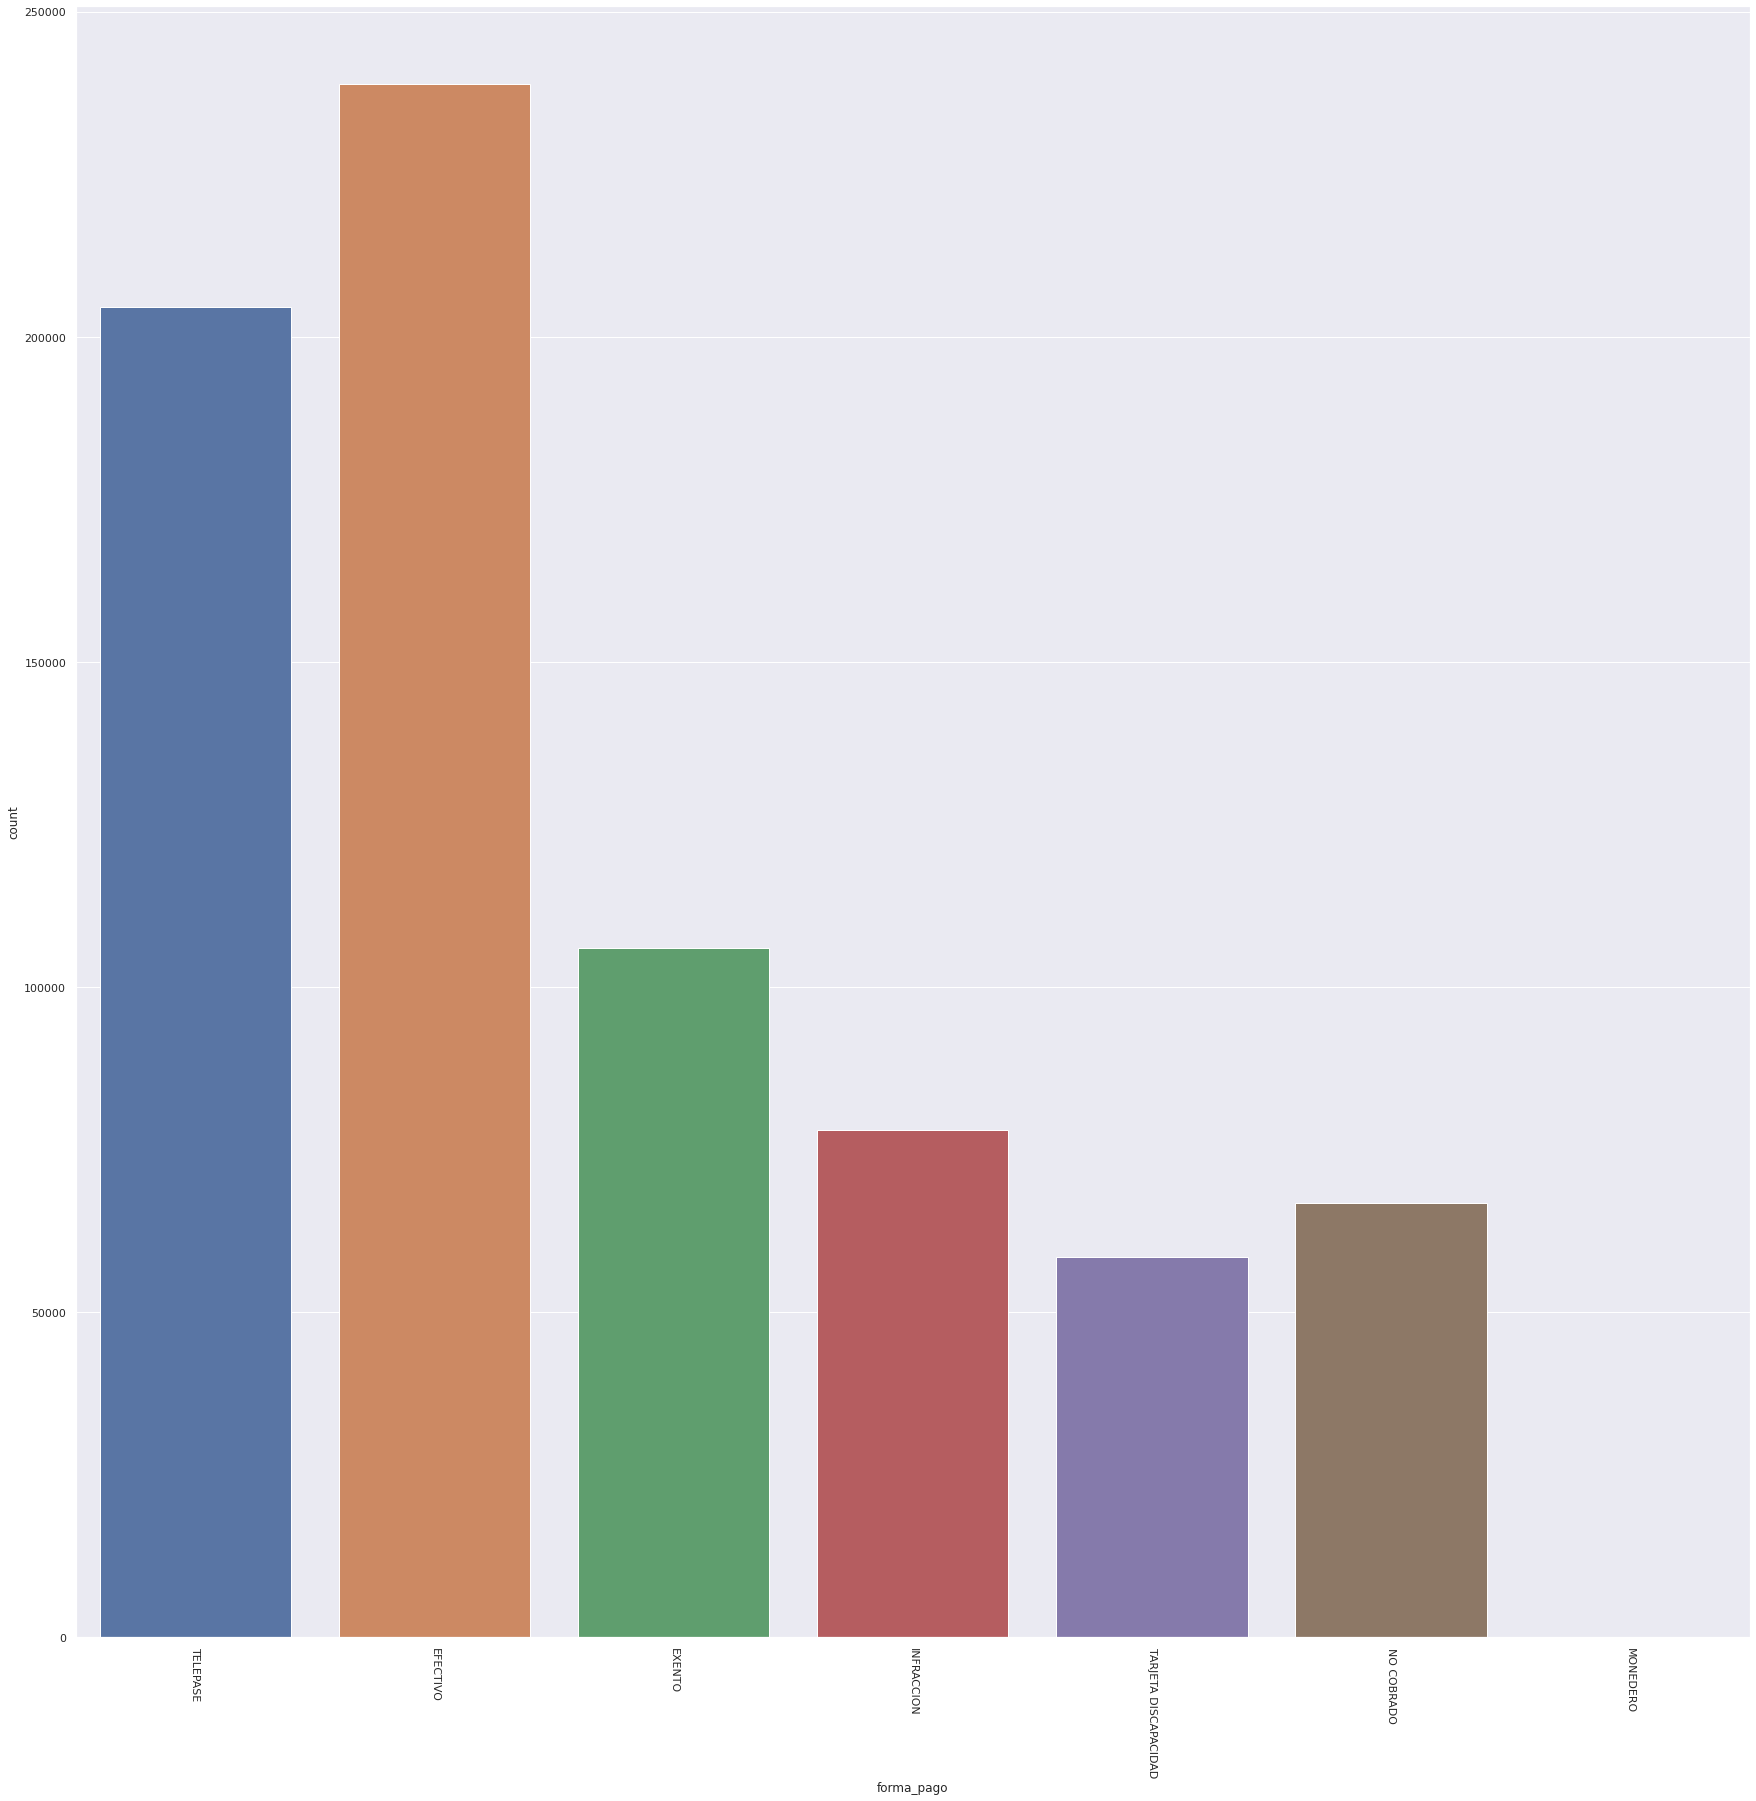

In [99]:
# Ahora analizo grafcamente cuales son los medios mas importantes
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="forma_pago", data=dataset)
plt.xticks(rotation=-90)

In [100]:
# Claramente los medios de pago mas importantes son TELEPASE Y EFECTIVO
# Me quedo con esos y Genero un nuevo dataset para cada uno
mascara =  (dataset.loc[:,'forma_pago'] == 'TELEPASE' ) 
data_t= dataset[mascara]
mascara =  (dataset.loc[:,'forma_pago'] == 'EFECTIVO' )
data_e= dataset[mascara]
print(data_t.shape,data_e.shape)

(204612, 6) (238869, 6)


In [101]:
#Resampleo los dos datasset para agrupar por dia
data_t = data_t.resample('D', on = 'fecha').sum()
data_e = data_e.resample('D', on = 'fecha').sum()
print(data_t.shape,data_e.shape)

(1095, 1) (1095, 1)


In [102]:
data_t.head()

cantidad_pasos
fecha                     
2017-01-01           12326
2017-01-02           35621
2017-01-03           39390
2017-01-04           40294
2017-01-05           41373

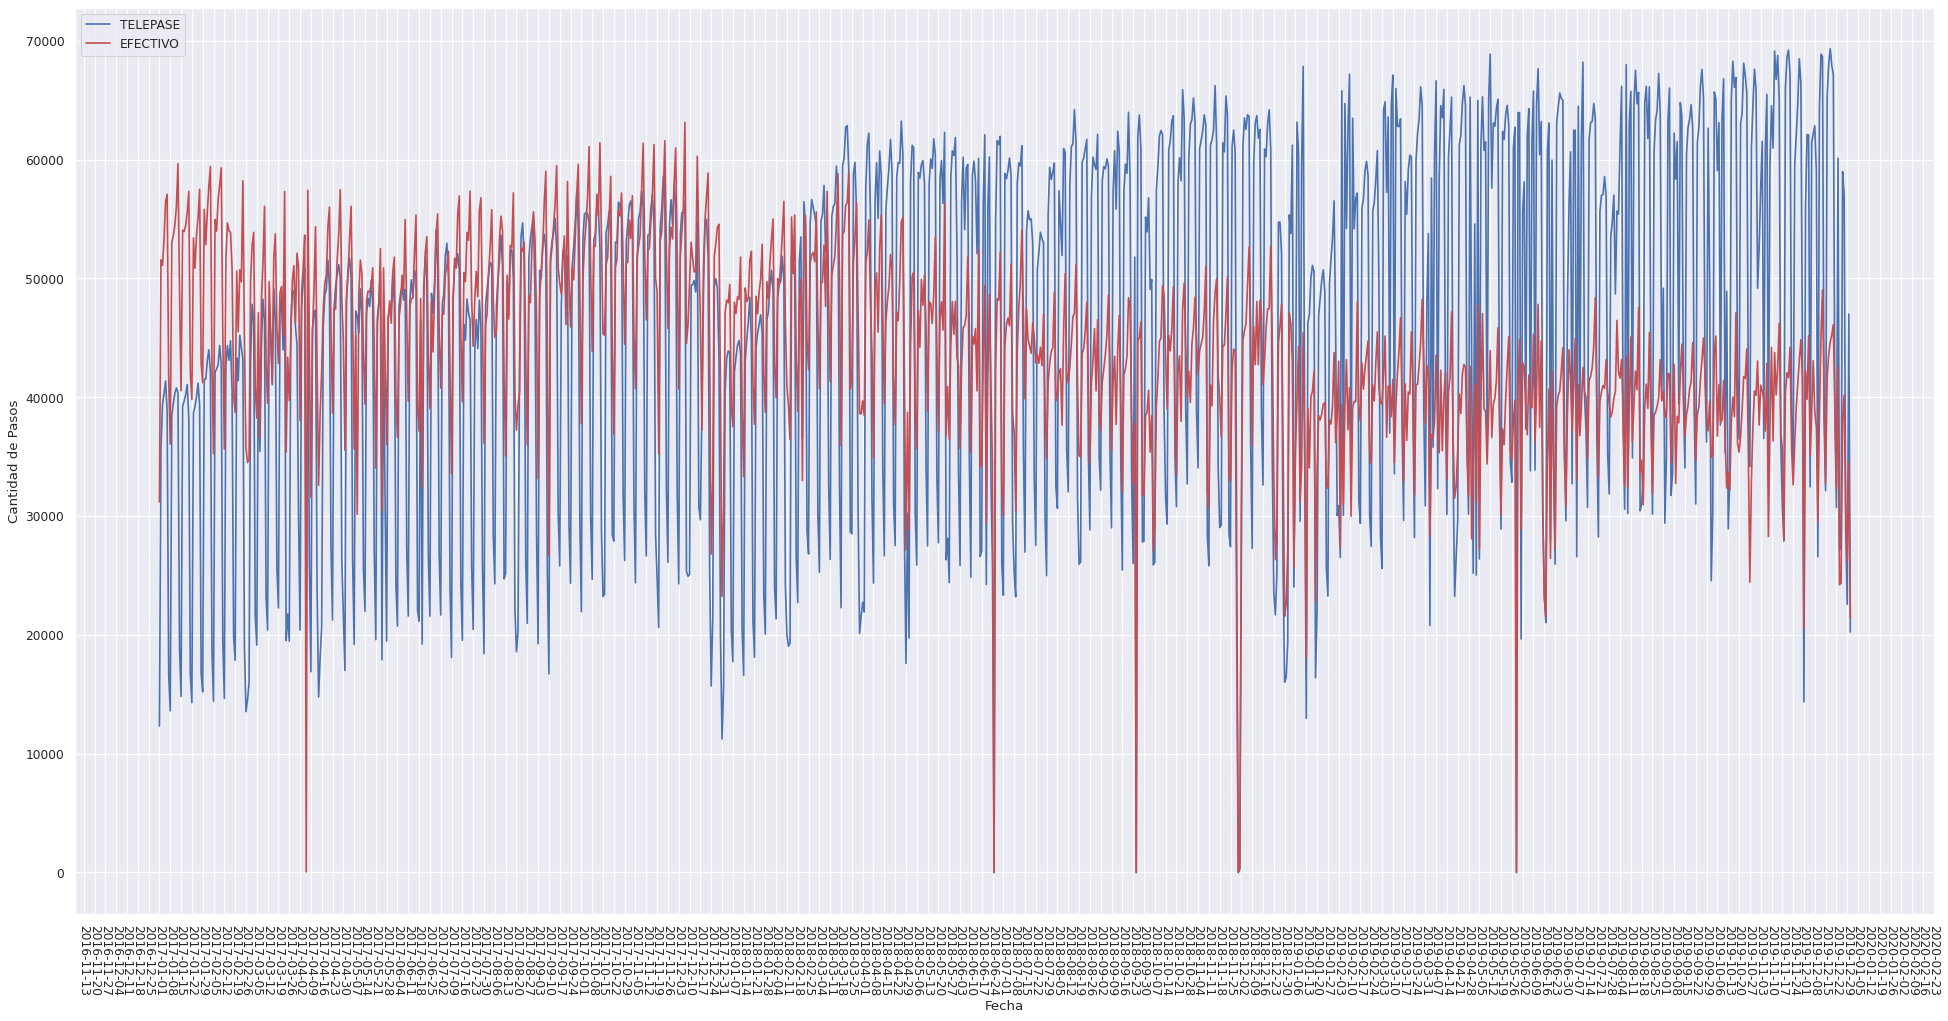

In [103]:
# Realizo las gráficas comparativas superpuestas a lo largo del tiempo
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(data_t.index, data_t.cantidad_pasos, 'b', label = 'TELEPASE')
plt.plot(data_e.index, data_e.cantidad_pasos, 'r', label = 'EFECTIVO')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [104]:
# Calculo la tendencia a travéz del Rolling Window
ventana = 200
promedio_tendencia_t = data_t.cantidad_pasos.rolling(window=ventana, center = True).mean()
promedio_tendencia_e = data_e.cantidad_pasos.rolling(window=ventana, center = True).mean()

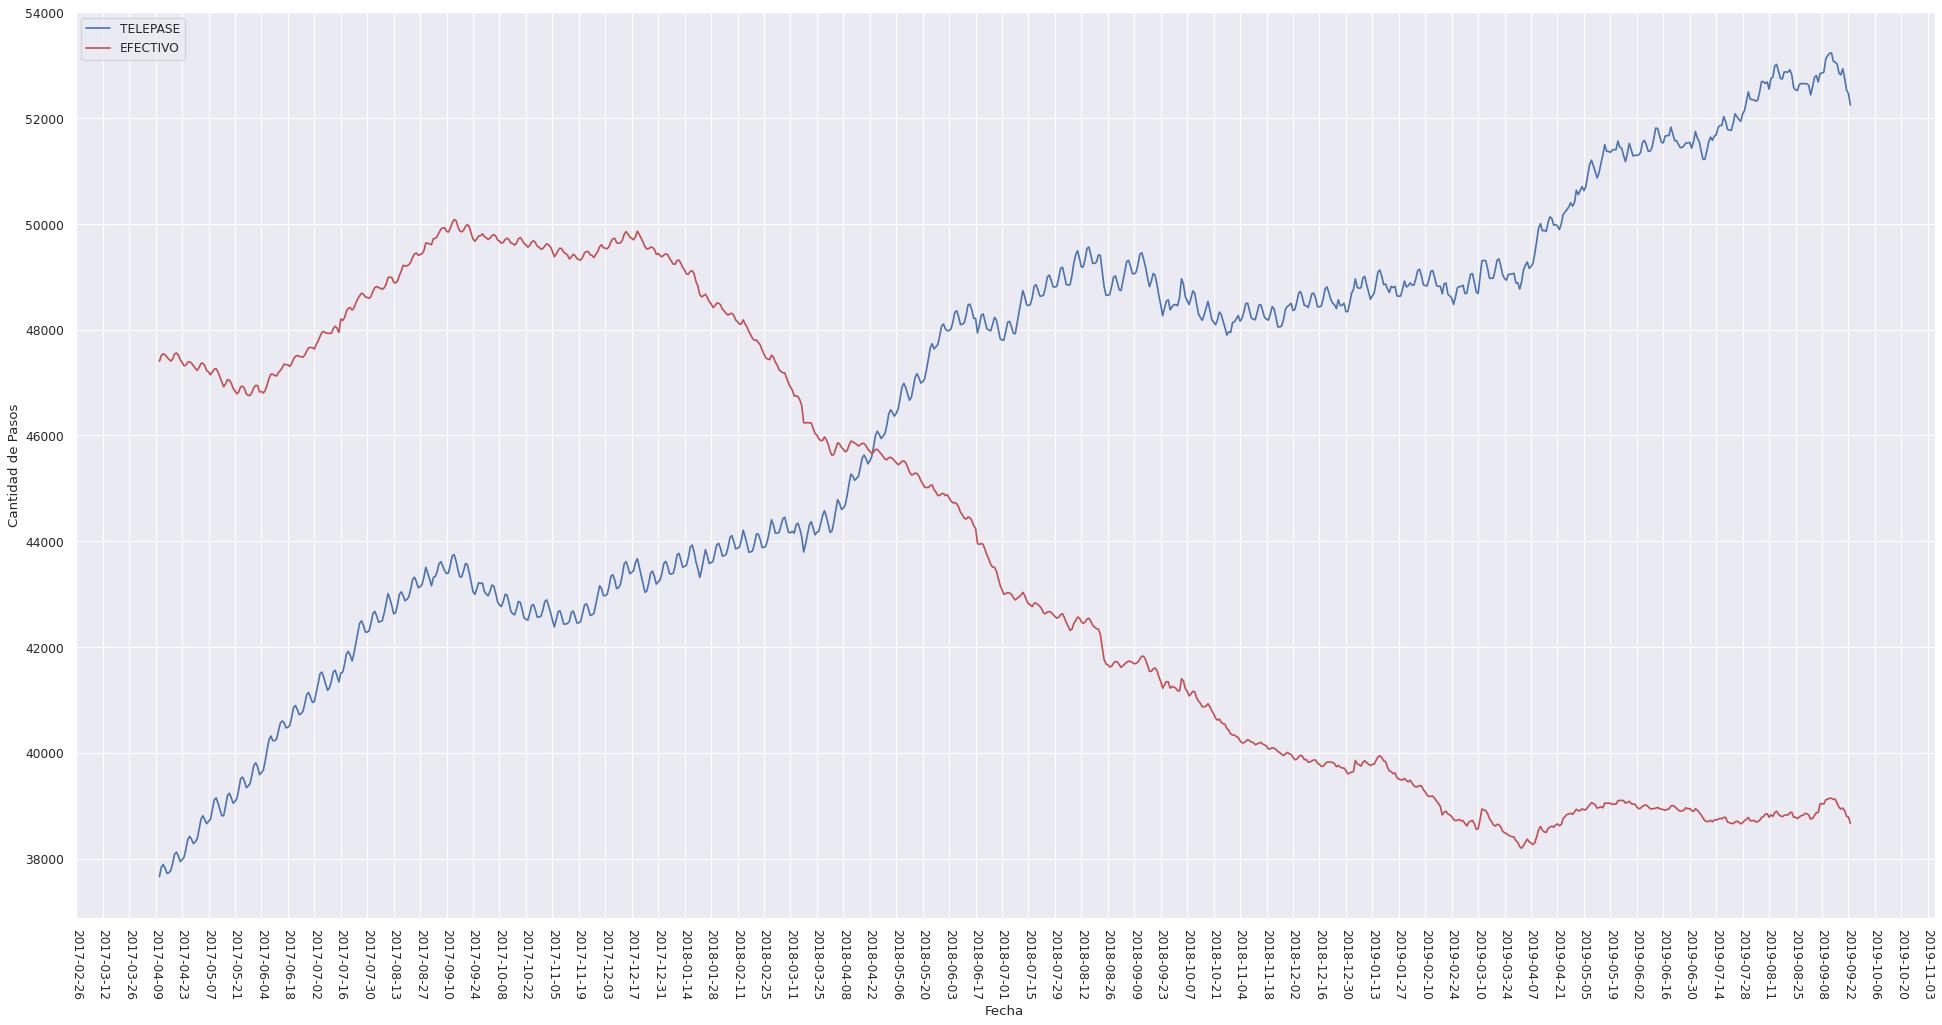

In [105]:
#Grafico 
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(data_t.index, promedio_tendencia_t, 'b', label = 'TELEPASE')
plt.plot(promedio_tendencia_e,  'r', label = 'EFECTIVO')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

### Conclusiones a partir de las correcciones
Claramente, a partir del 22-04-2018 TELEPASE empieza a superar al EFECTIVO. 
Esto cambia un poco las conclusiones anteriores dado que se puede analizar mas en profundidad la causa por la que la tendencia a abonar con efectivo fue decreciendo. 

Es evidente que cada vez mas usuarios de la autopista se tiren al uso del TELEPASE por una cuestión de practicidad, además de que en su momento había descuentos. 

Esto también habla de la automatización de los cobros en las autopistas. Un paso mas adelante sería el de implementar cámaras que a través de visión artificial lean las patentes de los vehículos y que se realice el cobro de forma automática. Si el sistema es lo suficientemente rápido para detectar los vehículos a gran velocidad, no sería necesario que se detengan o aminoren la marcha al pasar por una casilla de peajes. 


